In [1]:
from scipy.fft import fft
from scipy.linalg import expm
import time
import random
import json
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.sparse as ss
from scipy.optimize import minimize
from entforg import *
from IPython.display import display,Markdown,Latex


from qiskit.primitives import StatevectorEstimator
from qiskit import transpile
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.quantum_info import SparsePauliOp, Operator
from qiskit.synthesis import MatrixExponential, LieTrotter
from qiskit_nature.second_q.hamiltonians import QuadraticHamiltonian
from qiskit_nature.second_q.operators import FermionicOp
from qiskit_nature.second_q.mappers import JordanWignerMapper
from itertools import product
import math

from qiskit.quantum_info.operators import Pauli
from qiskit_nature.second_q.mappers.fermionic_mapper import FermionicMapper

from collections import defaultdict 
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from IPython.display import display
ME = MatrixExponential()

!!!!!!!!!!!!!!!!!!!!

Incluye la obtención de los términos diagonales cuadráticos (energías orbitales) teniendo en cuenta lo que aporten a estos el cambio de base de los cuadráticos, así como la creación del hamiltoniano problema a partir de los shifts y J dados, o la representación gráfica del espectro. También se guardan los valores de energías y matrices de rotación para todos los betas. El punto inicial es el dado por el paper HVA sin barren plateaus.

En cuanto a las ejecuciones ideales, estas se calculan por NumPy y no con el StatevectorEstimator para ahorrar tiempo.

También se añaden las gráficas que usan como figura de mérito la suma de los errores en las energías.

!!!!!!!!!!!!!!!!!!!!

### Definimos las distintas funciones que nos permitirán llevar a cabo las optimizaciones.

In [2]:
# Estas son funciones para visualizar de una forma más agradable las matrices resultantes.
def MatrixToLatex(A):
    a="\\begin{bmatrix}"
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            if ((j+1)%A.shape[1])==0:           
                a=a+"{0:.2f}".format(A[i,j])
            else:
                a=a+"%s&"%"{0:.2f}".format(A[i,j])
        if ((i+1)%A.shape[0])!=0:
            a=a+"\\\\"
    a=a+"\\end{bmatrix}"

    return(a)

def Display(string):
    display(Markdown(string))

    
def DisplayMatrix(A):
    A_Latex = MatrixToLatex(A)
    display(Markdown(A_Latex))

In [3]:
# Esta función calcula el hamiltoniano del problema, dados los valores de los shifts y el offset en ppm, de los J en Hz y de B en MHz. 
def Hspin(shifts, J, offset, B):
    # Leemos cuantos spines hay en el sistema.
    n=len(shifts)
    # Definimos los coeficientes que acompañarán a las cadenas de Pauli.
    w=[(shifts[i]-offset)*np.pi*B for i in range(n)]
    J2=[np.pi*J[i]/2 for i in range(len(J))]
    # Creamos las listas que guardarán los datos.
    pauli_strings = []
    coeffs=[]
    # Añadimos los términos correspondientes a los shifts.
    for i in range(n):
        string='I'*i+'Z'+'I'*(n-i-1)
        pauli_strings.append(string)
        coeffs.append(w[i])
    # Añadimos los términos correspondientes a los J.
    k=0
    for i in range(n):
        for j in range(n-i-1):
            strX='I'*i+'X'+'I'*j+'X'+'I'*(n-i-j-2)
            strY='I'*i+'Y'+'I'*j+'Y'+'I'*(n-i-j-2)
            strZ='I'*i+'Z'+'I'*j+'Z'+'I'*(n-i-j-2)
            pauli_strings.append(strX)
            coeffs.append(J2[k])
            pauli_strings.append(strY)
            coeffs.append(J2[k])
            pauli_strings.append(strZ)
            coeffs.append(J2[k])
            k+=1
    # Creamos y devolvemos el operador equivalente en la base de Pauli
    return SparsePauliOp.from_list(list(zip(pauli_strings, coeffs)))            

In [4]:
# Función necesaria para transformar los nombres de los elementos del diccionario que guarda la descomposición en operadores fermiónicos.
def transform_dict_keys(data):
    label_transformation = {
        "I": "",
        "N": "+_{} -_{}",
        "E": "-_{} +_{}",
        "+": "+_{}",
        "-": "-_{}",
    }

    new_data = {}
    for key, value in data.items():
        new_key_parts = []
        for i, char in enumerate(key):
            if char in label_transformation:
                # Apply transformation if the character is in the mapping
                transformed = label_transformation[char].format(i, i)
                if transformed:
                    new_key_parts.append(transformed)
        new_key = ' '.join(new_key_parts)  # Join the parts with spaces
        new_data[new_key] = value

    return new_data

# Función que transforma un operador descompuesto en cadenas de Pauli en un operador en la base fermiónica. 
# Aplica la transformación de Jordan-Wigner inversa.
def reverse_map(second_q_op: SparsePauliOp) -> FermionicOp:
        """Maps a class:`OperatorBase` to a `FermionicOp`.

        Args:
            second_q_op: the :class:`OperatorBase` to be mapped.

        Returns:
            The `FermionicOp` corresponding to the Hamiltonian in the Fermionic space.
        """

        num_qubits = second_q_op.num_qubits # get number of qubits from input second quantized operator
        fermionic_op = None
        for term in second_q_op:
            transform_list : List[Tuple(str, float)] = []  # list of tuple(pauli, coeff)
            coef_term = term.coeffs[0]  # Assuming coeffs is a list with a single element
            target_pauli_op = term.paulis[0]
            #print(target_pauli_op)

            for i in range(num_qubits):
                one_pauli = target_pauli_op[num_qubits - 1 - i]
                pauli_char=one_pauli.to_label()
                if pauli_char == 'Z': # dealing Pauli Z op
                    transform_list.append((('I',1),('N', -2))) # Zj -> I - 2*Nj => [('I', 1), ('N', -2)]
                elif pauli_char == 'X': # dealing Pauli X op
                    transform_list.append((("+", 1), ('-', 1))) # Xj -> aj_dag + aj => [('+', 1), ('-', 1)]
                    target_pauli_op &= Pauli("I" * (i+1) + "Z" * (num_qubits - i - 1)) # apply Z(j-1)Z(j-2) ... Z(0)
                elif one_pauli.to_label() == 'Y': # dealing Pauli Y op
                    transform_list.append((('+', 1j), ('-', -1j))) # Yj -> i(aj - aj_dag) => [('+', -1j), ('-', 1j)]
                    target_pauli_op &= Pauli("I" * (i+1) + "Z" * (num_qubits - i - 1)) # apply Z(j-1)Z(j-2) ... Z(0)
                else: 
                    # dealing Pauli I op
                    transform_list.append((('I', 0.5), ('I', 0.5))) # Ij -> Ij => [('I', 0.5), ('I', 0.5)]; split I into 0.5I + 0.5I for code consistency
            
            # dealing the phase
            if target_pauli_op.phase == 1:
                coef_term *= 1j
            elif target_pauli_op.phase == 2:
                coef_term *= -1
            elif target_pauli_op.phase == 3:
                coef_term *= -1j

            #print(transform_list)
            pauli_coefs = []
            pauli_strings = []
            # create fermionic operator for a term based on transform_list
            for idxes in product(*[[0, 1]]*num_qubits):
                pauli_coefs.append(math.prod([t[i][1] for t, i in zip(transform_list, idxes)]))
                pauli_strings.append("".join([t[i][0] for t, i in zip(transform_list, idxes)])[::-1])
            ferm_op=list(zip(pauli_strings, pauli_coefs))

            ferm_dict = defaultdict(float)

            # Iterate over each tuple in the list
            for key, value in ferm_op:
                # Sum the float values for tuples with the same string
                ferm_dict[key] += value

            ferm_dict_sparse=transform_dict_keys(ferm_dict)

            #print(ferm_dict)
            #print(ferm_dict_sparse)
            #print(coef_term)

            if not fermionic_op:
                fermionic_op = coef_term * FermionicOp(ferm_dict_sparse,num_spin_orbitals=num_qubits).simplify()
            else:
                fermionic_op += coef_term * FermionicOp(ferm_dict_sparse,num_spin_orbitals=num_qubits).simplify()

        return fermionic_op.simplify()

# Función que filtra los términos con dos operadores fermiónicos.
def filter_two_operator_terms(fermionic_op):
    """
    Filtra los términos con exactamente dos operadores del FermionicOp.

    Args:
        fermionic_op (FermionicOp): El operador fermiónico a filtrar.

    Returns:
        FermionicOp: Un nuevo FermionicOp con solo los términos de dos operadores.
    """
    filtered_data = {
        term: coeff
        for term, coeff in fermionic_op.items()
        if len(term.split()) == 2 or len(term.split())==0   # Solo términos con dos operadores
    }
    return FermionicOp(filtered_data, num_spin_orbitals=fermionic_op.num_spin_orbitals)

In [5]:
# Función que realiza el cambio de base del operador fermiónico, dada una matriz de cambio de base T.
def transform_fermionic_op(fermionic_op, T, T_conj):
    new_op_data = {}
    
    for term, coeff in fermionic_op.items():
        # Ignorar el término constante
        if term == '':
            new_op_data[''] = coeff
            continue
        
        # Expandir cada término en la nueva base
        new_terms = {}
        for t in term.split():
            op, idx = t[0], int(t[2])
            if op == '+':  # Transformación de operadores de creación
                new_operators = {f'+_{j}': T[j, idx] for j in range(len(T))}
            elif op == '-':  # Transformación de operadores de destrucción
                new_operators = {f'-_{j}': T_conj[j, idx] for j in range(len(T_conj))}
            
            # Combinar términos en la nueva base
            if not new_terms: # Si este término no existía, simplemente se guarda el nuevo.
                new_terms = new_operators
            else: # Si existía, se combinan los antiguos con los nuevos de esta iteración.
                new_terms = {
                    f"{k1} {k2}": v1 * v2
                    for k1, v1 in new_terms.items()
                    for k2, v2 in new_operators.items()
                }
        
        # Agregar al nuevo FermionicOp
        for new_term, new_coeff in new_terms.items():
            if new_term in new_op_data:
                new_op_data[new_term] += coeff * new_coeff
            else:
                new_op_data[new_term] = coeff * new_coeff

    return FermionicOp(new_op_data, num_spin_orbitals=len(T))


In [6]:
def filter_single_z_terms(sparse_pauli_op):
    """
    Filtra los términos en un SparsePauliOp que contienen exactamente una 'Z' y el resto son identidades ('I').

    Args:
        sparse_pauli_op (SparsePauliOp): El SparsePauliOp a filtrar.

    Returns:
         Dos SparsePauliOp: Un nuevo SparsePauliOp con los términos filtrados y otro con el resto de términos.
    """
    pauli_strings = sparse_pauli_op.paulis.to_labels()
    coeffs = sparse_pauli_op.coeffs

    # Filtrar términos con exactamente una 'Z' y el resto 'I'
    filtered_pauli_strings = []
    filtered_coeffs = []
    
    filtered_pauli_strings2 = []
    filtered_coeffs2 = []
    
    for pauli, coeff in zip(pauli_strings, coeffs):
        if (pauli.count('Z') == 1) and (pauli.count('I') == len(pauli) - 1):
            filtered_pauli_strings.append(pauli)
            filtered_coeffs.append(coeff)
        elif pauli.count('I') == len(pauli):
            filtered_pauli_strings.append(pauli)
            filtered_coeffs.append(coeff)
        else:
            filtered_pauli_strings2.append(pauli)
            filtered_coeffs2.append(coeff)

    # Crear y devolver el nuevo SparsePauliOp con los términos filtrados
    return SparsePauliOp.from_list(list(zip(filtered_pauli_strings, filtered_coeffs))), SparsePauliOp.from_list(list(zip(filtered_pauli_strings2, filtered_coeffs2)))

In [7]:
# Función que calcula el valor esperado de la energía del hamiltoniano total.
def expectation_classic(x, ansatz_U, beta, H_matrix, H_tot_matrix, cllbck = None):
    U_bound = ansatz_U.assign_parameters(x) # Dado un vector de parámetros, los asigna al operador unitario equivalente al circuito.
    U_matrix = Operator(U_bound).data # Obtenemos la matriz de este operador.

    # Obtenemos las energías como el valor esperado de H en el circuito que aplica U para cada vector de la base computacional.
    n=len(U_matrix)
    obs=SparsePauliOp.from_operator(Operator(H_matrix))

    Energies=np.zeros(n)
    for j in range(n):
        state0=np.zeros(n)
        state0[j]=1
        statenew=U_matrix@state0
        Energies[j]=np.real(np.dot(np.conj(statenew),np.dot(obs,statenew)))
    
    # Obtenemos el TFD a partir de estas energías y de la matriz U.
    TFD, _ = get_TFD(beta, U_matrix, np.conj(U_matrix), Energies)
    sTFD = ss.csr_matrix(TFD)
    # Obtenemos el valor esperado de la energía del hamiltoniano total en el estado dado por el TFD obtenido.
    total_energy = np.real(np.dot(np.conj(sTFD), np.dot(H_tot_matrix, sTFD.T)))[0,0]
    
    if cllbck is not None:
        cllbck(x, U_matrix)
    return total_energy
    
def callback(x):
    global x_arr
    x_arr.append(x)

# Función que calcula el valor de la energía libre.
def free_energy(x, ansatz_U, beta, H_matrix, H_tot_matrix, cllbck = None):
    U_bound = ansatz_U.assign_parameters(x) # Dado un vector de parámetros, los asigna al operador unitario equivalente al circuito.
    U_matrix = Operator(U_bound).data # Obtenemos la matriz de este operador.

    # Obtenemos las energías como el valor esperado de H en el circuito que aplica U para cada vector de la base computacional.
    n=len(U_matrix)
    obs=SparsePauliOp.from_operator(Operator(H_matrix))

    Energies=np.zeros(n)
    for j in range(n):
        state0=np.zeros(n)
        state0[j]=1
        statenew=U_matrix@state0
        Energies[j]=np.real(np.dot(np.conj(statenew),np.dot(obs,statenew)))
        
    # Obtenemos el valor de la energía libre.
    energia_libre=-sum(np.exp(-beta*Energies))/beta
    
    if cllbck is not None:
        cllbck(x, U_matrix)
    return energia_libre

In [8]:
# Función que crea el circuito que usamos como ansatz.
def ansatz_U(qubit_op,N_sites, reps=1):
    ansatz_U = QuantumCircuit(N_sites) # Creamos nuestro circuito de N spines
    # Obtenemos los grupos de conmutación de nuestro operador de espines, así como los términos con un solo operador Z.
    group_cuadratic, terms_non_cuadratic=filter_single_z_terms(qubit_op)
    groups=terms_non_cuadratic.group_commuting()
    count = 0

    # Aplicamos tantas repeticiones como se nos diga del circuito. Primero, se aplican bloques correspondientes a todos los grupos de conmutación
    # y, después, se aplica un bloque extra correspondiente a los términos con un solo operador Z.
    for r in range(reps):
        for d in range(len(groups)):
            ansatz_U.append(PauliEvolutionGate(groups[len(groups)-d-1], Parameter('t['+ str(count) + ']'), synthesis=ME), range(N_sites))
            count += 1
        ansatz_U.append(PauliEvolutionGate(group_cuadratic, Parameter('t['+ str(count) + ']'), synthesis=ME), range(N_sites))
        count += 1
    return ansatz_U

In [9]:
# Clases que nos permitirán representar el espectro, proporcionadas por Mestrelab.
class SpinSystem:
  def __init__(self):
    self.nucs = []
    self.jlist = []
    self.level =1
    
  def addNuc(self,name,shift):
      tn = nucleus(name,shift);
      self.nucs.append(tn)
      
  def addJ(self,name1,name2,j):
      tn = coupling(name1,name2,j);
      self.jlist.append(tn)
    
class nucleus:
    def __init__(self,name,shift):
      self.name = name
      self.shift = shift
      
class coupling:
    def __init__(self,name1,name2,j):
      self.name1 = name1
      self.name2=name2
      self.j = j
        
class NMRSimulator:
    E= np.matrix([[1, 0],[0, 1]])
    Ix = np.matrix([[0, 1/2],[1/2, 0]])
    Iy= np.matrix([[0, -1J/2], [1J/2, 0]])
    Iz = np.matrix([[1/2,0],[0,-1/2]])   
      
    def __init__(self):
      #std operators        
  

      # SET SIM parameters here
      self.field =400   
      self.swp = 10
      self.setOffsetPPM( 5)
      self.setTD(2**14)
      self.setT2(2);
      self.debug=False
      #self.noise=1/2000
      self.nucleus="1H"
      
    def setField(self,field):
        self.field=field
        self.offsetH = self.offset*self.field
        
    def setSWPPM(self,swp): 
        self.swp=swp
        self.swh=swp*self.field
        self.dw=1/self.swh
        
    def setOffsetPPM(self,offset):
        self.offset=offset
        self.offsetH = self.offset*self.field
        
    def setTD(self,td):
        self.td=int(td)
        
    def setT2(self, t2):
        self.t2=t2
      
    def getOperator (op, n):
        for i in range(n):
            if i==0:
                h=op
            else:
                h=NMRSimulator.E
            for j in range (1,n):
                if i==j:
                    h2=op
                else:
                    h2=NMRSimulator.E
                h=np.kron(h,h2)
            if(i==0):
                H=h
            else:
                H=H+h
        return H;
    
      
    def makeHamiltonian(self, ss):
        for n in ss.nucs:
            ind = ss.nucs.index(n)
            #print('nuc ' + n.name + ' ' +  str(ind))
            if ind==0:
                h=NMRSimulator.Iz
            else:
                h=NMRSimulator.E
            for i in range (1,len(ss.nucs)):
                if ind==i:
                    h2=NMRSimulator.Iz
                else:
                    h2=NMRSimulator.E
                h=np.kron(h,h2)
            h = h * np.pi*2 * (n.shift * self.field - self.offsetH)
            if(ind==0):
                H=h
            else:
                H=H+h
            
        #print('done nucs')
        for j in ss.jlist:
            ind1 = NMRSimulator.getIndexForName(j.name1, ss.nucs)
            ind2 = NMRSimulator.getIndexForName(j.name2, ss.nucs)
            #print (str(ind1) + '   ' + str(ind2))
            if ind1==0 or ind2==0:
                hx=NMRSimulator.Ix
                hy=NMRSimulator.Iy
                hz=NMRSimulator.Iz
                #print('ind0 hx')
            else:
                hx=NMRSimulator.E
                hy=NMRSimulator.E
                hz=NMRSimulator.E
                #print('ind0 E')
            for i in range (1,len(ss.nucs)):
                if ind1==i or ind2==i:
                    hx2=NMRSimulator.Ix
                    hy2=NMRSimulator.Iy
                    hz2=NMRSimulator.Iz
                    #print('indi hx')
                else:
                    hx2=NMRSimulator.E
                    hy2=NMRSimulator.E
                    hz2=NMRSimulator.E
                    #print('indi E')
                hx=np.kron(hx,hx2)
                hy=np.kron(hy,hy2)
                hz=np.kron(hz,hz2)
            H= H + 2*np.pi*j.j*(hx + hy + hz)
        return H

    def getIndexForName(name, nucs):
        for l in nucs:
            ind = nucs.index(l)
            if(l.name == name):
                return ind;
        

        
    def simSpinSystem(self, ss):
        H = self.makeHamiltonian(ss)
        m0 = NMRSimulator.getOperator(NMRSimulator.Ix,len(ss.nucs))
        IxT = m0
        IyT = NMRSimulator.getOperator(NMRSimulator.Iy,len(ss.nucs))
        vals,vecs = LA.eigh(H)
        vecsi = LA.inv(vecs)
        diag = np.diag(vals)
        fidr  = np.empty(self.td);
        fidi  = np.empty(self.td);
        t = np.empty(self.td);
        ff = self.t2/(2*np.pi)

        fac = ss.level / 2**len(ss.nucs)    
        mMat = vecsi @ m0 @ vecs
        if(self.debug):
            print('made matrices ' + str(time.process_time() - self.start))
        for x in range (self.td):
            t[x]=x*self.dw
            tm =  vecs @ expm(-1J * t[x] * diag) @ mMat @ expm(1J * t[x] * diag) @ vecsi
            fac2 =  np.exp(-x*self.dw/ff) * fac
            fidr[x] = np.real(np.trace(tm*IxT) * fac2)
            fidi[x] = np.real(np.trace(tm*IyT) * fac2)
        if(self.debug):
            print('made fid ' + str(time.process_time() - self.start))
        return fidr,fidi,tm, vals, vecs
    
    def simSpinSystemQuantum(self, ss, vals, vecs, m_x, m_y):
    
        m0 = m_x
        IxT = m_x
        IyT = m_y
        
        vecsi = LA.inv(vecs)
        diag = np.diag(vals)
        fidr  = np.empty(self.td);
        fidi  = np.empty(self.td);
        t = np.empty(self.td);
        ff = self.t2/(2*np.pi)
        fac = ss.level / 2**len(ss.nucs)    
        mMat = vecsi @ m0 @ vecs
        if(self.debug):
            print('made matrices ' + str(time.process_time() - self.start))
        for x in range (self.td):
            t[x]=x*self.dw
            tm = vecs @ expm(-1J * t[x] * diag) @ mMat @ expm(1J * t[x] * diag) @ vecsi
            fac2 =  np.exp(-x*self.dw/ff) * fac
            fidr[x] = np.real(np.trace(tm @ IxT) * fac2)
            fidi[x] = np.real(np.trace(tm @ IyT) * fac2)
        if(self.debug):
            print('made fid ' + str(time.process_time() - self.start))
        return fidr,fidi,tm, vals, vecs
    
#    def getNoise(self):
#        u = random.random(); 
#        v = random.random();
#        return math.sqrt(-2.0 * math.log(u)) * math.cos(2.0 * np.pi * v) * self.noise;
#    
#    def addNoise(self,re,im):
#        for i in range(len(re)):
#            re[i]=re[i]+self.getNoise()
#            im[i]=im[i]+self.getNoise()

    def simSpectrum(self, sss, sc=1.0, b=0.0):

        fidrSum  = np.zeros(self.td);
        fidiSum  = np.zeros(self.td);
        self.start = time.process_time()
        for ss in sss: 
            fidr,fidi,tm, vals, vecs = self.simSpinSystem(ss)
            fidrSum = fidr + fidrSum
            fidiSum = fidi + fidiSum
        
        fidrSum  = fidrSum * sc 
        fidiSum = fidiSum * sc
        
        #self.addNoise(fidrSum,fidiSum)
        spcr = fft(fidrSum)
        spci = fft(fidiSum)
        if(self.debug):
            print('done fft ' + str(time.process_time() - self.start))
        spc = spcr-1J*spci
        spcOut = np.empty(self.td);
        fs = np.empty(self.td);
        td2 =int(self.td/2)
        for i in range(td2):
            spcOut[td2+i]=np.real(spc[i])
            spcOut[i] =np.real(spc[td2+i])
            fs[i] = (1/self.dw/2 - i/td2/self.dw/2)/self.field + self.offset
            fs[self.td-i-1]=(-1/self.dw/2 + i/td2/self.dw/2) / self.field + self.offset
        if(self.debug):
            print('all done ' + str(time.process_time() - self.start))
        spcOut = spcOut - np.amin(spcOut)
        spcOut = spcOut + b
        return spcOut,fs, vals, vecs
    
    def simSpectrumQuantum(self, sss, vals, vecs, m_x, m_y, sc=1.0, b=0.0):

        fidrSum  = np.zeros(self.td);
        fidiSum  = np.zeros(self.td);
        self.start = time.process_time()
        for ss in sss: 
            fidr,fidi,tm, vals, vecs = self.simSpinSystemQuantum(ss, vals, vecs, m_x, m_y)
            fidrSum = fidr + fidrSum
            fidiSum = fidi + fidiSum
        
        fidrSum  = fidrSum * sc 
        fidiSum = fidiSum * sc
        
        #self.addNoise(fidrSum,fidiSum)
        spcr = fft(fidrSum)
        spci = fft(fidiSum)
        if(self.debug):
            print('done fft ' + str(time.process_time() - self.start))
        spc = spcr-1J*spci
        spcOut = np.empty(self.td);
        fs = np.empty(self.td);
        td2 =int(self.td/2)
        for i in range(td2):
            spcOut[td2+i]=np.real(spc[i])
            spcOut[i] = np.real(spc[td2+i])
            fs[i] = (1/self.dw/2 - i/td2/self.dw/2)/self.field + self.offset
            fs[self.td-i-1]=(-1/self.dw/2 + i/td2/self.dw/2) / self.field + self.offset
        if(self.debug):
            print('all done ' + str(time.process_time() - self.start))
        spcOut = spcOut - np.amin(spcOut)
        spcOut = spcOut + b
        return spcOut,fs, vals, vecs

In [10]:
# Funciones que nos permitirán crear la magnetizacion.
def local_spin_x(N_sites):
    ham=[]
    for i in range(0,N_sites):
        string='I'*i+'X'+'I'*(N_sites-1-i)
        ham.append(string)
    return ham

def local_spin_y(N_sites):
    ham=[]
    for i in range(0,N_sites):
        string='I'*i+'Y'+'I'*(N_sites-1-i)
        ham.append(string)
    return ham

In [11]:
# Función que transforma la magnetización según la matriz dada por la transformada de Bogoliubov.
def transform_M(T,Mx,My):
    T_conj=T
    # Transformamos la matrix dada a operadores fermiónicos mediante una Jordan-Wigner inversa.
    mag_fx=reverse_map(Mx)
    mag_fy=reverse_map(My)
    
    mag_new_x=transform_fermionic_op(mag_fx,T,T_conj)
    mag_new_y=transform_fermionic_op(mag_fy,T,T_conj)
    # Aplicamos una transformación de Jordan-Wigner sobre el operador fermiónico transformado para devolverlo a su expresión en operadores de espín.
    mag_mom_x=JW.map(mag_new_x.simplify()).chop(1e-6)
    mag_mom_y=JW.map(mag_new_y.simplify()).chop(1e-6)
    return mag_mom_x,mag_mom_y#, mag_fy

In [12]:
# Definimos la función que representa el espectro obtenido frente al teórico.
def reprSpectrum(shifts,J,d,SW,B,offset,energ,U,T,xlim=None,ylim=None,reprteo=True):
    # Construimos el SpinSystem asociado, añadiendo los shifts primero y los acoplamientos J después.
    sscase = SpinSystem()
    n=len(shifts)
    for i in range(n):
        sscase.addNuc(str(i), shifts[i])
    k=0
    for i in range(n):
        for j in range(i+1,n):
            sscase.addJ(str(i), str(j), J[k])
            k+=1
    sscase.level=1

    # Construimos las matrices de las magnetizaciones
    m_x=SparsePauliOp(local_spin_x(n),coeffs=0.5)
    m_y=SparsePauliOp(local_spin_y(n),coeffs=0.5)

    # Transformamos las matrices a la base correspondiente.
    mag_x, mag_y=transform_M(T,m_x,m_y)
    
    # Construimos el simulador NMR
    nmrsim = NMRSimulator()
    nmrsim.setField(B)
    nmrsim.setTD(d) # Resolución del espectro
    nmrsim.setSWPPM(SW) # Ancho espectral
    nmrsim.setOffsetPPM(offset)
    nmrsim.setT2(2.0)
    sss = []
    sss.append(sscase)
    # Calculamos el espectro a partir de las energías y la matriz U dadas
    spcOut, fs, v, w = nmrsim.simSpectrumQuantum(sss, energ, U, mag_x.to_matrix(),mag_y.to_matrix())
    # Calculamos el espectro teórico
    spcOutteo, fsteo, v, w= nmrsim.simSpectrum(sss)
    # Representamos ambos espectros para comparar.
    if reprteo:
        plt.plot(fsteo, spcOutteo,'-', label='Theoretical Spectrum', color='red',lw=2)
    plt.plot(fs, spcOut, '-', label='Experimental Spectrum', color='black',alpha=0.8)
    if xlim is not None:
        plt.xlim(xlim[0],xlim[1])
    if ylim is not None:
        plt.ylim(ylim[0],ylim[1])
    plt.legend()
    plt.grid()
    plt.show()

In [35]:
# Función que realiza la minimización para un hamiltoniano dado (en base de espines) y unos valores de beta. 
# La función que se minimiza puede escogerse con el argumento function.
def minimize_function(H, function, betas):
    # Medimos el tiempo que tarada la optimización.
    start=time.time()
    # Obtenemos el número de espines correspondiente al hamiltoniano dado.
    N_sites=H.num_qubits
    # Transformamos la descomposición obtenida a operadores fermiónicos mediante una Jordan-Wigner inversa.
    fermionic_op= reverse_map(H)


    # Creamos la matriz que guardará los coeficientes de la parte cuadrática del operador fermiónico. 
    num_spin_orbitals = fermionic_op.num_spin_orbitals
    h1 = np.zeros((num_spin_orbitals, num_spin_orbitals), dtype=np.complex128)
    
    # Extraemos términos cuadráticos.
    for term, coeff in fermionic_op.items():
        if term.count('+')==0 and term.count('-') == 0:
            cte=coeff
        elif term.count('+') == 1 and term.count('-') == 1:  # Verifica que tenga un operador de creación y uno de destrucción
            # Extraer los índices y los signos de los operadores
            indices = [int(t[2]) for t in term.split()]
            signs = [t[0] for t in term.split()]
            
            # Determinar las posiciones en la matriz según los signos
            if signs == ['+', '-']:  # Caso +_i -_j
                h1[indices[0], indices[1]] += coeff
            elif signs == ['-', '+']:  # Caso -_i +_j
                h1[indices[1], indices[0]] -= coeff  # Cambiar el signo del coeficiente

    # Obtenemos la matriz de cambio de base a una en la que la parte cuadrática sea diagonal mediante la transformación de Bogoliubov.
    # También obtenemos los valores diagonales, las energías orbitales.
    hamiltonian = QuadraticHamiltonian(
        hermitian_part=h1,
        constant=cte)
    (transformation_matrix,
        orbital_energies,
        transformed_constant,
    ) = hamiltonian.diagonalizing_bogoliubov_transform()
    
    # Definimos la matriz de transformación
    T =transformation_matrix
    # Obtener la matriz conjugada transpuesta para transformar operadores de destrucción
    T_conj=T
    # T_conj = np.array(np.matrix(transformation_matrix).getH())
    # Transformamos el FermionicOp a la nueva base.
    fermionic_op_new = transform_fermionic_op(fermionic_op, T, T_conj)

    # Obtenemos los términos diagonales cuadráticos teniendo en cuenta lo que aporten a estos el cambio de base de los cuadráticos
    orbital_energies_fixed=np.array([np.real(fermionic_op_new['+_'+str(i)+' '+'-_'+str(i)]) for i in range(N_sites)])
    
    # Dividimos por un factor las energías orbitales para evitar problemas numéricos.
    factor=1000
    omega=orbital_energies_fixed/factor

    # Aplicamos una transformación de Jordan-Wigner sobre el operador fermiónico transformado para devolverlo a su expresión en operadores de espín.
    qubit_op=JW.map(fermionic_op_new.simplify())
    coeffs = qubit_op.coeffs
    pauli_strings = qubit_op.paulis.to_labels()
    new_coeffs=np.real(coeffs)
    qubit_op=SparsePauliOp.from_list(list(zip(pauli_strings, new_coeffs))).simplify()
    # Construimos el ansatz a partir de este operador.
    ansatz=ansatz_U(qubit_op,N_sites)
    gate_number = ansatz.num_parameters
    # Obtenemos los valores teóricos de energías y autovectores asociados para comparar posteriormente los resultados obtenidos.
    H_q=qubit_op/factor
    H_matrix = H_q.to_matrix()
    E_L, U_L = np.linalg.eigh(H_matrix)
    obs=SparsePauliOp.from_operator(H_q)
    # Creamos los hamiltonianos H_L y H_R
    identity = SparsePauliOp.from_list([('I'*N_sites, 1)])
    H_L = H_q^identity                 # H_L = H \otimes I
    H_R = (identity^H_q).conjugate()   # H_R = I \otimes H*

    # Creamos un vector en el que vamos a guardar los valores de los overlaps y del número de iteraciones realizadas para cada valor de beta.
    overlaps_TFD = np.zeros(len(betas))
    niter=np.zeros(len(betas))
    # Tambiéncreamos listas donde vamos a guardar los valores de las energías así como la matriz de rotación obtenidas para cada beta.
    energ=[]
    U=[]
    bnds=[(-2*np.pi,2*np.pi)]*gate_number
    # Realizamos la minimización para cada valor de beta dado.
    for i, beta in enumerate(betas):
        # Creamos el hamiltoniano de interacción
        H_int_q = quita_Z(JW.map(create_H_int(beta, omega, N_sites)))
        
        # Creamos el hamiltoniano total
        H_tot = H_L + H_R + H_int_q
        H_tot_matrix = H_tot.to_matrix(sparse=True)
        H_tot_matrix.eliminate_zeros()
    
        # Calculamos el TFD teórico
        TFD_exact = get_TFD(beta, U_L, np.conj(U_L), E_L)[0]

        x0 = np.random.random(gate_number)*2*np.pi
        x0sum=sum(x0)
        x0=x0*np.pi/(2*N_sites*x0sum)

        # Realizamos la minimización de la función elegida como parámetro.
        
        method='SLSQP'
        min_result = minimize(function, x0=x0, args=(ansatz, beta, H_matrix, H_tot_matrix), tol=1e-10, method=method, bounds=bnds)
        # Calculamos la matriz asociada al circuito unitario para los parámetros obtenidos de la minimización.
        U_bound = ansatz.assign_parameters(min_result.x)
        U_matrix = Operator(U_bound).data
        U.append(U_matrix)
        
        # Calculamos las energías para esa matriz y obtenemos el TFD resultado de la optimización.
        # Obtenemos las energías como el valor esperado de H en el circuito que aplica U para cada vector de la base computacional.
        n=len(U_matrix)
        Energies=np.zeros(n)
        for j in range(n):
            state0=np.zeros(n)
            state0[j]=1
            statenew=U_matrix@state0
            Energies[j]=np.real(np.dot(np.conj(statenew),np.dot(obs,statenew)))
    
        energ.append(Energies)
        

        TFD_opt = get_TFD(beta, U_matrix, np.conj(U_matrix), Energies)[0]

        # Calculamos el overlap entre ambos TFD como el módulo del producto escalar de estos.
        overlaps_TFD[i] = np.abs(np.dot(np.conj(TFD_exact), TFD_opt))
        # Guardamos el número final de iteraciones realizadas.
        if 'nit' in min_result.keys():
            niter[i]=min_result.nit
    end=time.time()
    return overlaps_TFD, energ, U, niter, end-start, T

In [14]:
factor=1000

### Sulfanol

In [45]:
betas = list(np.linspace(0.001,1,20))+list(np.linspace(2,5,10))

In [46]:
# Construimos H para el Sulfanol.
offset=5
B=400
shifts=[3.44,7.40]
J=[2.32]
matrizSulfanol=Hspin(shifts,J,offset,B)

In [47]:
results_expect, energies_expect, UExpect, niterExpect, tExpect, TExp=minimize_function(matrizSulfanol,expectation_classic,betas)
results_free_energy, energies_free_energy, UFE, niterFE, tFE, TFE=minimize_function(matrizSulfanol,free_energy,betas)

In [48]:
print('El tiempo que ha tardado la optimización minimizando el valor esperado de la energía en el hamiltoniano total es '+str(tExpect)+' s.')
print('El tiempo que ha tardado la optimización minimizando la energía libre es '+str(tFE)+' s.')

El tiempo que ha tardado la optimización minimizando el valor esperado de la energía en el hamiltoniano total es 0.3359541893005371 s.
El tiempo que ha tardado la optimización minimizando la energía libre es 0.38376665115356445 s.


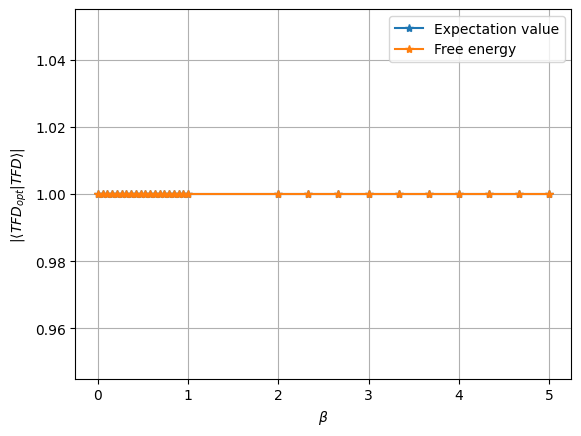

In [49]:
plt.plot(betas, results_expect, '*-', label='Expectation value')
plt.plot(betas, results_free_energy, '*-', label='Free energy')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$|\langle TFD_{opt} | TFD \rangle|$')
plt.legend()
plt.grid()
plt.show()

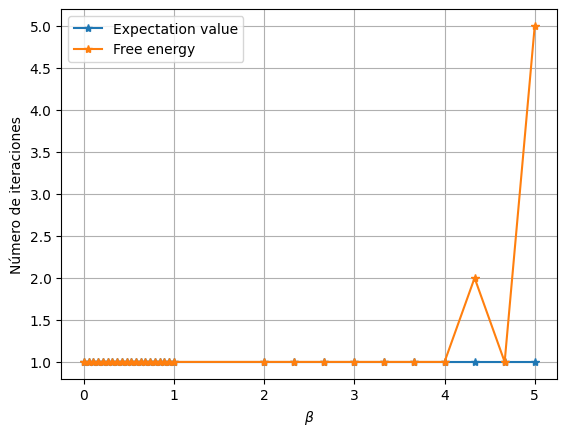

In [50]:
plt.plot(betas, niterExpect, '*-', label='Expectation value')
plt.plot(betas, niterFE, '*-', label='Free energy')
plt.xlabel(r'$\beta$')
plt.ylabel(r'Número de iteraciones')
plt.legend()
plt.grid()
plt.show()

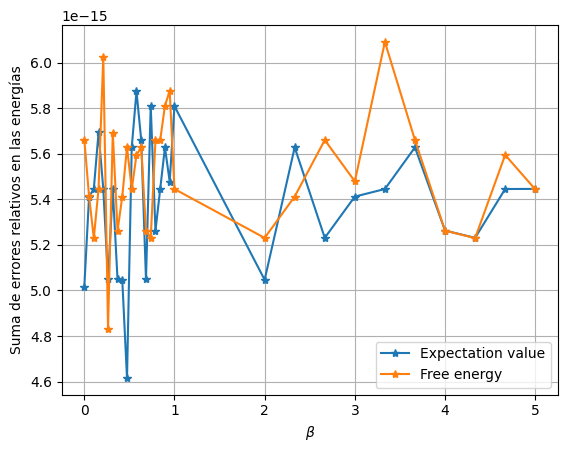

In [51]:
Eteo=np.sort(np.linalg.eig(matrizSulfanol.to_matrix())[0])
Eexpect=[np.sort(energies_expect[i])*factor for i in range(len(betas))] 
Efreeenerg=[np.sort(energies_free_energy[i])*factor for i in range(len(betas))]
relerrorExpect=[sum([abs((Eexpect[i][j]-Eteo[j])/Eteo[j]) for j in range(len(Eteo))]) for i in range(len(betas))]
relerrorFE=[sum([abs((Efreeenerg[i][j]-Eteo[j])/Eteo[j]) for j in range(len(Eteo))]) for i in range(len(betas))]
plt.plot(betas, relerrorExpect, '*-', label='Expectation value')
plt.plot(betas, relerrorFE, '*-', label='Free energy')
plt.xlabel(r'$\beta$')
plt.ylabel(r'Suma de errores relativos en las energías')
plt.legend()
plt.grid()
plt.show()

In [52]:
results_expect

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [53]:
results_free_energy

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [54]:
sort_index=[np.argsort(energies_expect[i]) for i in range(len(betas))]
int(sort_index[0][0])

1

In [55]:
# Energías obtenidas minimizando el valor esperado de la energía en el hamiltoniano total.
np.sort(energies_expect[-1])*factor

array([-4979.9323483 , -1051.93088413,  1059.21937908,  4972.64385334])

In [56]:
# Energías obtenidas minimizando el valor esperado de la energía libre.
np.sort(energies_free_energy[-1])*factor

array([-4979.9323483 , -1051.93088413,  1059.21937908,  4972.64385334])

In [57]:
# Valores teóricos para las energías.
np.sort(np.linalg.eig(matrizSulfanol.to_matrix())[0])

array([-4979.9323483 +0.j, -1051.93088413+0.j,  1059.21937908+0.j,
        4972.64385334+0.j])

In [58]:
DisplayMatrix(UFE[-1])

\begin{bmatrix}0.99+0.11j&0.00+0.00j&0.00+0.00j&0.00+0.00j\\0.00+0.00j&0.58-0.81j&0.00+0.00j&0.00+0.00j\\0.00+0.00j&0.00+0.00j&-0.59-0.81j&0.00+0.00j\\0.00+0.00j&0.00+0.00j&0.00+0.00j&-0.99+0.10j\end{bmatrix}

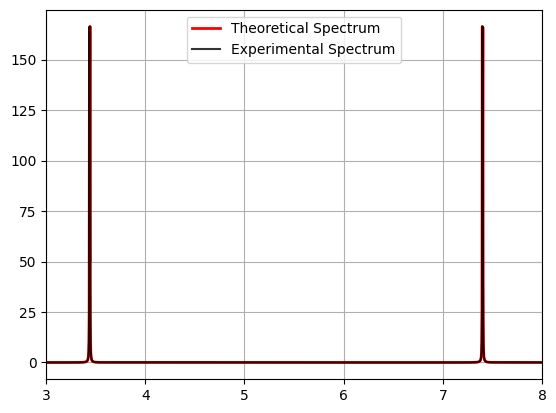

In [59]:
SW=10
d=10**5
reprSpectrum(shifts,J,d,SW,B,offset,energies_free_energy[-1]*factor,UFE[-1],TFE,xlim=[3,8])

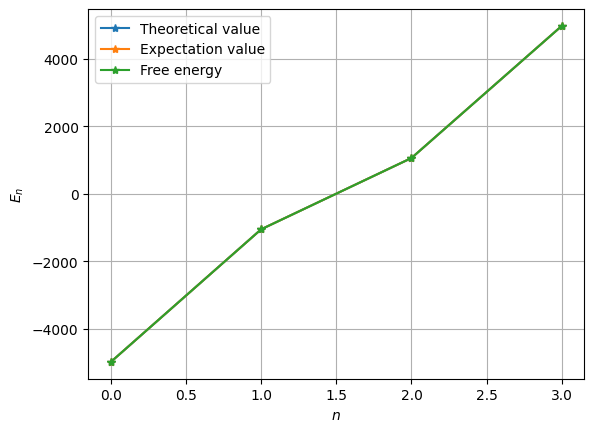

In [60]:
n=len(Eteo)
plt.plot(range(n), np.real(Eteo), '*-', label='Theoretical value')
plt.plot(range(n), Eexpect[-1], '*-', label='Expectation value')
plt.plot(range(n), Efreeenerg[-1], '*-', label='Free energy')
plt.xlabel(r'$n$')
plt.ylabel(r'$E_n$')
plt.legend()
plt.grid()
plt.show()

### AB system

In [61]:
betas = list(np.linspace(0.001,1,20))+list(np.linspace(2,5,10))

In [62]:
# Construimos H para el sistema AB.
offset=5
B=400
shifts=[1,1.025]
J=[10]
matrizAB=Hspin(shifts,J,offset,B)

In [63]:
results_expect, energies_expect, UExpect, niterExpect, tExpect, TExp=minimize_function(matrizAB,expectation_classic,betas)
results_free_energy, energies_free_energy, UFE, niterFE, tFE, TFE=minimize_function(matrizAB,free_energy,betas)

In [64]:
print('El tiempo que ha tardado la optimización minimizando el valor esperado de la energía en el hamiltoniano total es '+str(tExpect)+' s.')
print('El tiempo que ha tardado la optimización minimizando la energía libre es '+str(tFE)+' s.')

El tiempo que ha tardado la optimización minimizando el valor esperado de la energía en el hamiltoniano total es 0.33547186851501465 s.
El tiempo que ha tardado la optimización minimizando la energía libre es 0.44441866874694824 s.


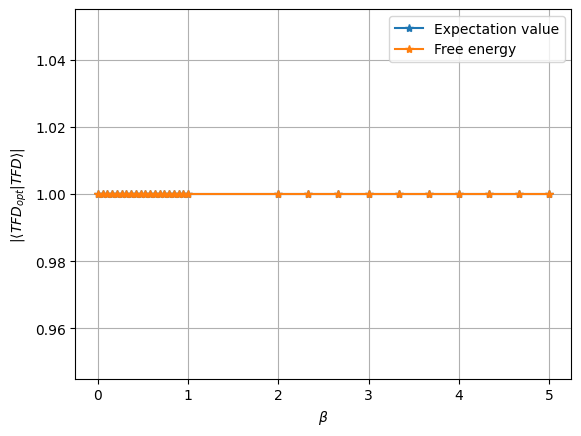

In [65]:
plt.plot(betas, results_expect, '*-', label='Expectation value')
plt.plot(betas, results_free_energy, '*-', label='Free energy')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$|\langle TFD_{opt} | TFD \rangle|$')
plt.legend()
plt.grid()
plt.show()

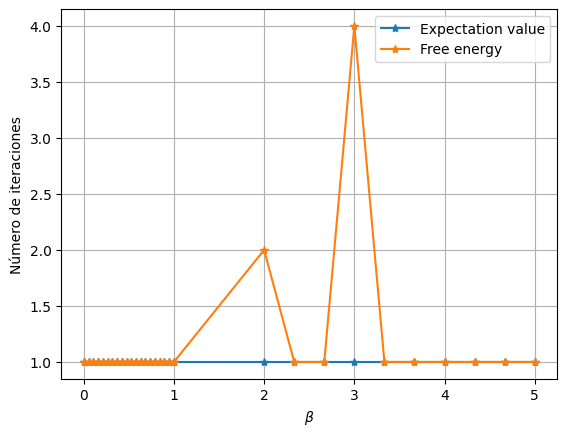

In [66]:
plt.plot(betas, niterExpect, '*-', label='Expectation value')
plt.plot(betas, niterFE, '*-', label='Free energy')
plt.xlabel(r'$\beta$')
plt.ylabel(r'Número de iteraciones')
plt.legend()
plt.grid()
plt.show()

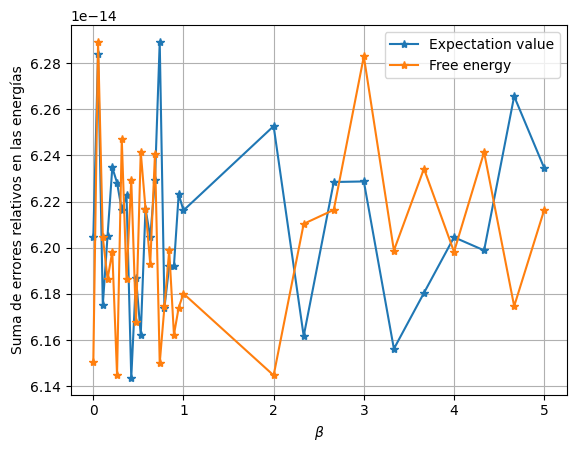

In [67]:
Eteo=np.sort(np.linalg.eig(matrizAB.to_matrix())[0])
Eexpect=[np.sort(energies_expect[i])*factor for i in range(len(betas))] 
Efreeenerg=[np.sort(energies_free_energy[i])*factor for i in range(len(betas))]
relerrorExpect=[sum([abs((Eexpect[i][j]-Eteo[j])/Eteo[j]) for j in range(len(Eteo))]) for i in range(len(betas))]
relerrorFE=[sum([abs((Efreeenerg[i][j]-Eteo[j])/Eteo[j]) for j in range(len(Eteo))]) for i in range(len(betas))]
plt.plot(betas, relerrorExpect, '*-', label='Expectation value')
plt.plot(betas, relerrorFE, '*-', label='Free energy')
plt.xlabel(r'$\beta$')
plt.ylabel(r'Suma de errores relativos en las energías')
plt.legend()
plt.grid()
plt.show()

In [68]:
results_expect

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [69]:
results_free_energy

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [70]:
DisplayMatrix(np.linalg.eig(matrizAB.to_matrix())[1])

\begin{bmatrix}-0.00-0.00j&0.00+0.00j&1.00+0.00j&0.00+0.00j\\0.38-0.00j&0.92+0.00j&0.00+0.00j&0.00+0.00j\\0.92+0.00j&-0.38+0.00j&0.00+0.00j&0.00+0.00j\\-0.00-0.00j&0.00+0.00j&0.00+0.00j&1.00+0.00j\end{bmatrix}

In [71]:
DisplayMatrix(UFE[-1])

\begin{bmatrix}-0.72+0.70j&0.00+0.00j&0.00+0.00j&0.00+0.00j\\0.00+0.00j&0.43+0.90j&0.00+0.00j&0.00+0.00j\\0.00+0.00j&0.00+0.00j&-0.45+0.89j&0.00+0.00j\\0.00+0.00j&0.00+0.00j&0.00+0.00j&0.73+0.68j\end{bmatrix}

In [72]:
# Energías obtenidas minimizando el valor esperado de la energía en el hamiltoniano total.
np.sort(energies_expect[-1])*factor

array([-10005.97260168,    -60.13679265,     28.72086611,  10037.38852822])

In [73]:
# Energías obtenidas minimizando el valor esperado de la energía libre.
np.sort(energies_free_energy[-1])*factor

array([-10005.97260168,    -60.13679265,     28.72086611,  10037.38852822])

In [74]:
# Valores teóricos para las energías.
np.sort(np.linalg.eig(matrizAB.to_matrix())[0])

array([-10005.97260168+0.j,    -60.13679265+0.j,     28.72086611+0.j,
        10037.38852822+0.j])

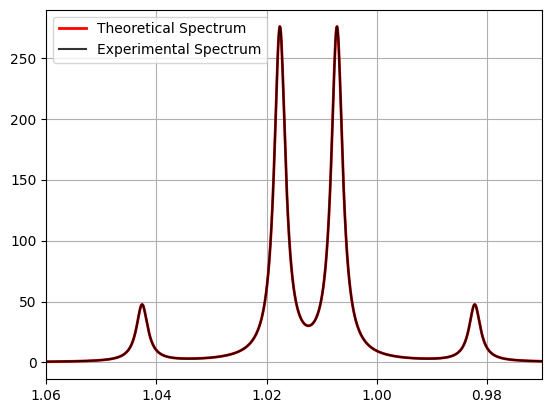

In [75]:
reprSpectrum(shifts,J,d,SW,B,offset,energies_free_energy[-1]*factor,UFE[-1], TFE,xlim=[1.06,0.97])

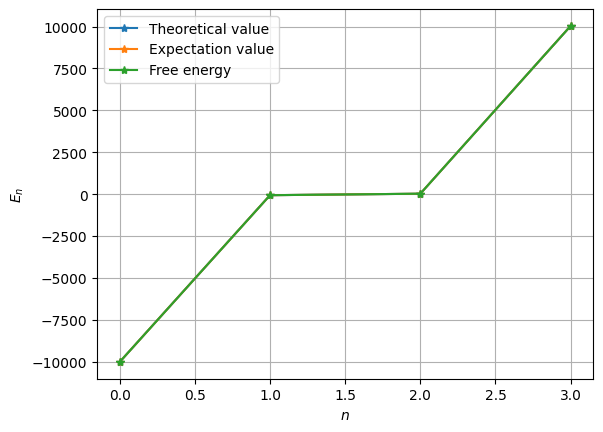

In [76]:
n=len(Eteo)
plt.plot(range(n), np.real(Eteo), '*-', label='Theoretical value')
plt.plot(range(n), Eexpect[-1], '*-', label='Expectation value')
plt.plot(range(n), Efreeenerg[-1], '*-', label='Free energy')
plt.xlabel(r'$n$')
plt.ylabel(r'$E_n$')
plt.legend()
plt.grid()
plt.show()

### AX system

In [77]:
betas = list(np.linspace(0.001,1,20))+list(np.linspace(2,5,10))

In [78]:
# Construimos H para el sistema AX.
offset=5
B=400
shifts=[1,1.2]
J=[4]
matrizAX=Hspin(shifts,J,offset,B)

In [79]:
results_expect, energies_expect, UExpect, niterExpect, tExpect, TExp=minimize_function(matrizAX,expectation_classic,betas)
results_free_energy, energies_free_energy, UFE, niterFE, tFE, TFE=minimize_function(matrizAX,free_energy,betas)

In [80]:
print('El tiempo que ha tardado la optimización minimizando el valor esperado de la energía en el hamiltoniano total es '+str(tExpect)+' s.')
print('El tiempo que ha tardado la optimización minimizando la energía libre es '+str(tFE)+' s.')

El tiempo que ha tardado la optimización minimizando el valor esperado de la energía en el hamiltoniano total es 0.3346860408782959 s.
El tiempo que ha tardado la optimización minimizando la energía libre es 0.47303009033203125 s.


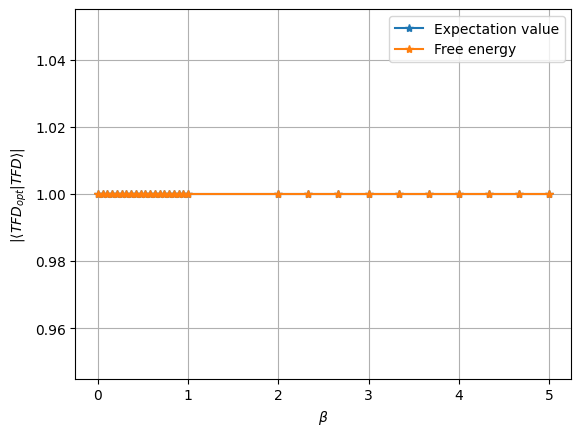

In [81]:
plt.plot(betas, results_expect, '*-', label='Expectation value')
plt.plot(betas, results_free_energy, '*-', label='Free energy')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$|\langle TFD_{opt} | TFD \rangle|$')
plt.legend()
plt.grid()
plt.show()

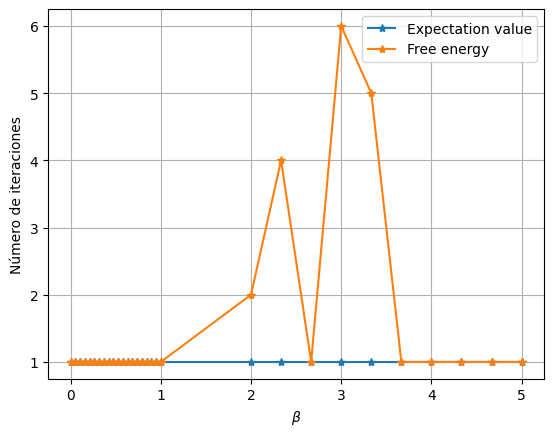

In [82]:
plt.plot(betas, niterExpect, '*-', label='Expectation value')
plt.plot(betas, niterFE, '*-', label='Free energy')
plt.xlabel(r'$\beta$')
plt.ylabel(r'Número de iteraciones')
plt.legend()
plt.grid()
plt.show()

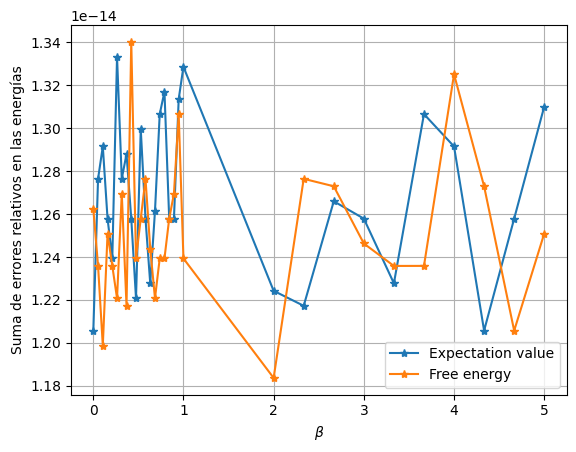

In [83]:
Eteo=np.sort(np.linalg.eig(matrizAX.to_matrix())[0])
Eexpect=[np.sort(energies_expect[i])*factor for i in range(len(betas))] 
Efreeenerg=[np.sort(energies_free_energy[i])*factor for i in range(len(betas))]
relerrorExpect=[sum([abs((Eexpect[i][j]-Eteo[j])/Eteo[j]) for j in range(len(Eteo))]) for i in range(len(betas))]
relerrorFE=[sum([abs((Efreeenerg[i][j]-Eteo[j])/Eteo[j]) for j in range(len(Eteo))]) for i in range(len(betas))]
plt.plot(betas, relerrorExpect, '*-', label='Expectation value')
plt.plot(betas, relerrorFE, '*-', label='Free energy')
plt.xlabel(r'$\beta$')
plt.ylabel(r'Suma de errores relativos en las energías')
plt.legend()
plt.grid()
plt.show()

In [84]:
results_expect

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [85]:
results_free_energy

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [86]:
# Energías obtenidas minimizando el valor esperado de la energía en el hamiltoniano total.
np.sort(energies_expect[-1])*factor

array([-9795.48589389,  -257.92456076,   245.35819014,  9808.05226451])

In [87]:
# Energías obtenidas minimizando el valor esperado de la energía libre.
np.sort(energies_free_energy[-1])*factor

array([-9795.48589389,  -257.92456076,   245.35819014,  9808.05226451])

In [88]:
# Valores teóricos para las energías.
np.sort(np.linalg.eig(matrizAX.to_matrix())[0])

array([-9795.48589389+0.j,  -257.92456076+0.j,   245.35819014+0.j,
        9808.05226451+0.j])

In [89]:
DisplayMatrix(UFE[-1])

\begin{bmatrix}0.63-0.77j&0.00+0.00j&0.00+0.00j&0.00+0.00j\\0.00+0.00j&-0.86-0.51j&0.00+0.00j&0.00+0.00j\\0.00+0.00j&0.00+0.00j&-0.48+0.87j&0.00+0.00j\\0.00+0.00j&0.00+0.00j&0.00+0.00j&0.15+0.99j\end{bmatrix}

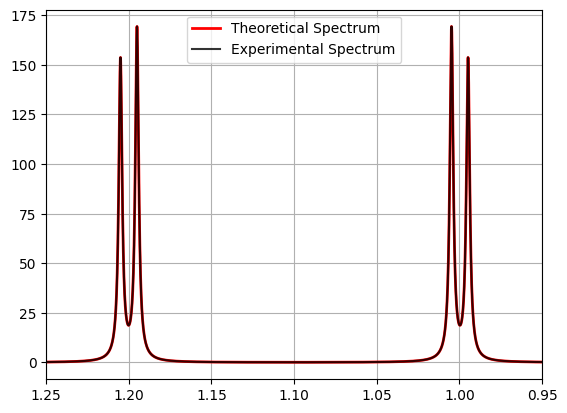

In [90]:
reprSpectrum(shifts,J,d,SW,B,offset,energies_free_energy[-1]*factor,UFE[-1], TFE,xlim=[1.25,0.95])

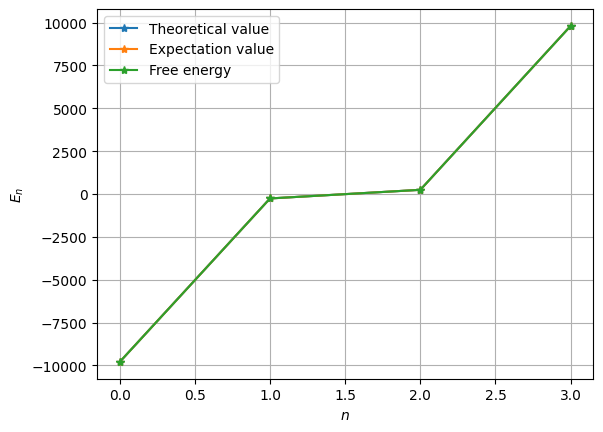

In [91]:
n=len(Eteo)
plt.plot(range(n), np.real(Eteo), '*-', label='Theoretical value')
plt.plot(range(n), Eexpect[-1], '*-', label='Expectation value')
plt.plot(range(n), Efreeenerg[-1], '*-', label='Free energy')
plt.xlabel(r'$n$')
plt.ylabel(r'$E_n$')
plt.legend()
plt.grid()
plt.show()

### AMX system

In [219]:
betas = list(np.linspace(0.001,1,100))+list(np.linspace(1,10,100))

In [220]:
# Construimos H para el sistema AMX.
offset=5
B=400
shifts=[1,1.2,1.5]
J=[3,10,8]
matrizAMX=Hspin(shifts,J,offset,B)

In [221]:
results_expect, energies_expect, UExpect, niterExpect, tExpect, TExp=minimize_function(matrizAMX,expectation_classic,betas)
results_free_energy, energies_free_energy, UFE, niterFE, tFE, TFE=minimize_function(matrizAMX,free_energy,betas)

In [222]:
print('El tiempo que ha tardado la optimización minimizando el valor esperado de la energía en el hamiltoniano total es '+str(tExpect)+' s.')
print('El tiempo que ha tardado la optimización minimizando la energía libre es '+str(tFE)+' s.')

El tiempo que ha tardado la optimización minimizando el valor esperado de la energía en el hamiltoniano total es 79.65313196182251 s.
El tiempo que ha tardado la optimización minimizando la energía libre es 80.62854552268982 s.


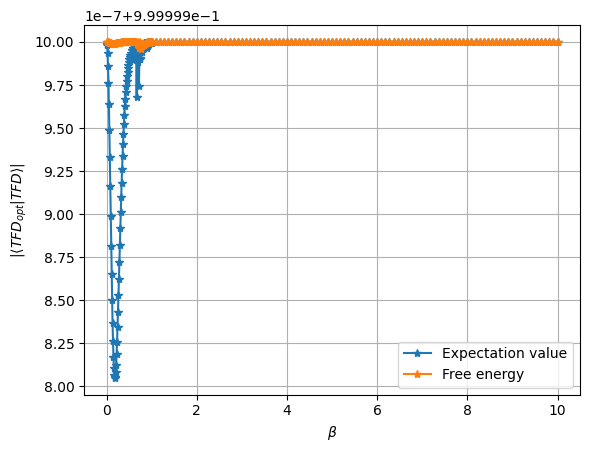

In [223]:
plt.plot(betas, results_expect, '*-', label='Expectation value')
plt.plot(betas, results_free_energy, '*-', label='Free energy')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$|\langle TFD_{opt} | TFD \rangle|$')
plt.legend()
plt.grid()
plt.show()

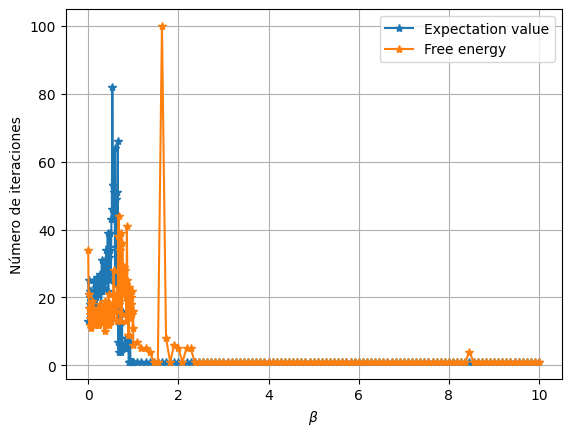

In [224]:
plt.plot(betas, niterExpect, '*-', label='Expectation value')
plt.plot(betas, niterFE, '*-', label='Free energy')
plt.xlabel(r'$\beta$')
plt.ylabel(r'Número de iteraciones')
plt.legend()
plt.grid()
plt.show()

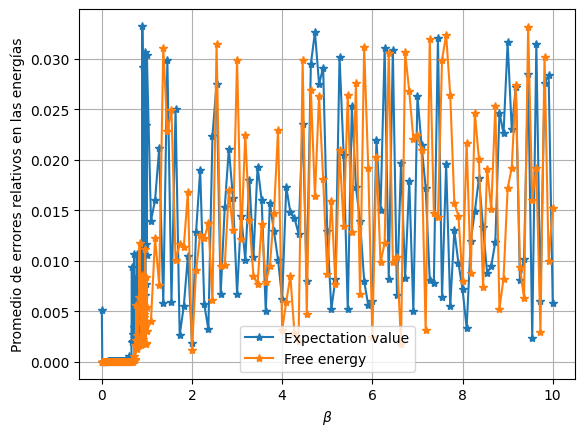

In [225]:
Eteo=np.sort(np.linalg.eig(matrizAMX.to_matrix())[0])
Eexpect=[np.sort(energies_expect[i])*factor for i in range(len(betas))] 
Efreeenerg=[np.sort(energies_free_energy[i])*factor for i in range(len(betas))]
relerrorExpect=[1/(len(Eteo))*sum([abs((Eexpect[i][j]-Eteo[j])/Eteo[j]) for j in range(len(Eteo))]) for i in range(len(betas))]
relerrorFE=[1/(len(Eteo))*sum([abs((Efreeenerg[i][j]-Eteo[j])/Eteo[j]) for j in range(len(Eteo))]) for i in range(len(betas))]
plt.plot(betas, relerrorExpect, '*-', label='Expectation value')
plt.plot(betas, relerrorFE, '*-', label='Free energy')
plt.xlabel(r'$\beta$')
plt.ylabel(r'Promedio de errores relativos en las energías')
plt.legend()
plt.grid()
plt.show()

In [226]:
index=np.argmin(relerrorFE)

In [227]:
relerrorFE[index]

np.float64(3.0068355412557363e-07)

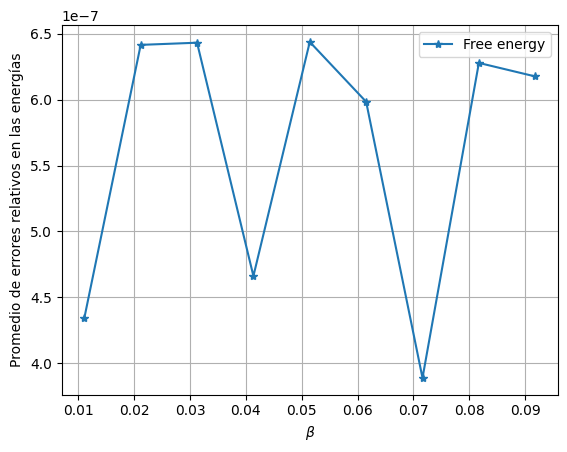

In [228]:
Eteo=np.sort(np.linalg.eig(matrizAMX.to_matrix())[0])
Eexpect=[np.sort(energies_expect[i])*factor for i in range(len(betas))] 
Efreeenerg=[np.sort(energies_free_energy[i])*factor for i in range(len(betas))]
relerrorExpect=[1/(len(Eteo))*sum([abs((Eexpect[i][j]-Eteo[j])/Eteo[j]) for j in range(len(Eteo))]) for i in range(len(betas))]
relerrorFE=[1/(len(Eteo))*sum([abs((Efreeenerg[i][j]-Eteo[j])/Eteo[j]) for j in range(len(Eteo))]) for i in range(len(betas))]
# plt.plot(betas[1:10], relerrorExpect[1:10], '*-', label='Expectation value')
plt.plot(betas[1:10], relerrorFE[1:10], '*-', label='Free energy')
plt.xlabel(r'$\beta$')
plt.ylabel(r'Promedio de errores relativos en las energías')
plt.legend()
plt.grid()
plt.show()

In [229]:
results_expect

array([1.        , 1.        , 0.99999999, 0.99999999, 0.99999998,
       0.99999996, 0.99999995, 0.99999993, 0.99999992, 0.9999999 ,
       0.99999988, 0.99999987, 0.99999985, 0.99999984, 0.99999983,
       0.99999982, 0.99999981, 0.99999981, 0.9999998 , 0.99999981,
       0.99999981, 0.99999981, 0.99999982, 0.99999983, 0.99999983,
       0.99999984, 0.99999985, 0.99999986, 0.99999987, 0.99999988,
       0.99999989, 0.9999999 , 0.99999991, 0.99999992, 0.99999993,
       0.99999993, 0.99999994, 0.99999995, 0.99999995, 0.99999996,
       0.99999996, 0.99999997, 0.99999997, 0.99999997, 0.99999998,
       0.99999998, 0.99999998, 0.99999998, 0.99999999, 0.99999999,
       0.99999999, 0.99999999, 0.99999999, 0.99999999, 0.99999999,
       1.        , 1.        , 1.        , 1.        , 0.99999999,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.99999997, 0.99999999, 0.99999999, 0.99999999,
       0.99999999, 0.99999997, 0.99999999, 0.99999999, 0.99999

In [230]:
results_free_energy

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [231]:
# Energías obtenidas minimizando el valor esperado de la energía en el hamiltoniano total.
np.sort(energies_expect[-1])*factor

array([-14167.01207136,  -5428.67353922,  -4650.53387587,  -4153.77810199,
         4189.79447682,   4708.56870741,   5268.64888713,  14232.98551709])

In [232]:
# Energías obtenidas minimizando el valor esperado de la energía libre.
np.sort(energies_free_energy[-1])*factor

array([-14167.01207136,  -5428.67353922,  -4650.53387587,  -4153.77810199,
         4145.35197281,   4942.94100131,   5078.71909724,  14232.98551709])

In [233]:
# Valores teóricos para las energías.
np.sort(np.linalg.eig(matrizAMX.to_matrix())[0])

array([-14167.01207136+0.j,  -5428.67353922+0.j,  -4650.53387587+0.j,
        -4153.77810199+0.j,   4138.10193822+0.j,   4647.26099524+0.j,
         5381.6491379 +0.j,  14232.98551709+0.j])

In [234]:
DisplayMatrix(UFE[1])

\begin{bmatrix}0.75-0.67j&0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j\\0.00+0.00j&-0.15+0.99j&-0.00-0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j\\0.00+0.00j&0.00+0.00j&0.86-0.52j&0.00+0.00j&-0.00-0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j\\0.00+0.00j&0.00+0.00j&0.00+0.00j&0.94+0.34j&0.00+0.00j&0.00-0.00j&0.02-0.05j&0.00+0.00j\\0.00+0.00j&0.00-0.00j&0.00-0.00j&0.00+0.00j&0.84+0.54j&0.00+0.00j&0.00+0.00j&0.00+0.00j\\0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j&-0.03+1.00j&0.00+0.00j&0.00+0.00j\\0.00+0.00j&0.00+0.00j&0.00+0.00j&-0.05-0.02j&0.00+0.00j&-0.00-0.00j&0.34-0.94j&0.00+0.00j\\0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j&0.00+0.00j&-0.18-0.98j\end{bmatrix}

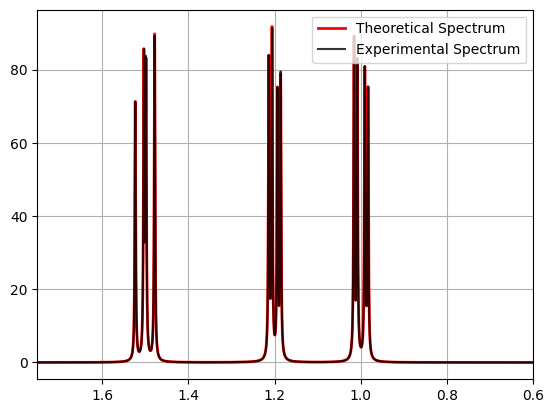

In [235]:
d=10**5
SW=10
reprSpectrum(shifts,J,d,SW,B,offset,energies_free_energy[1]*factor,UFE[1], TFE,xlim=[1.75,0.6])

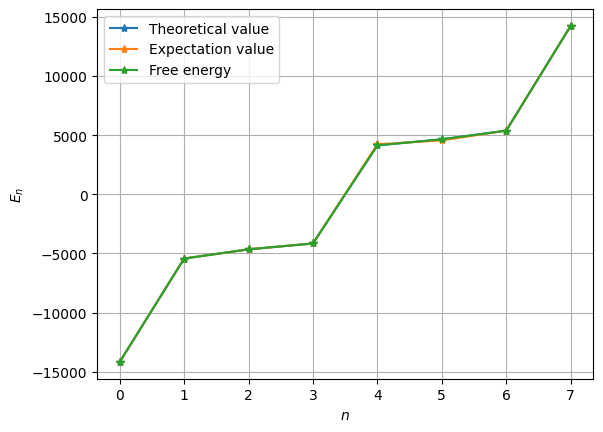

In [236]:
n=len(Eteo)
plt.plot(range(n), np.real(Eteo), '*-', label='Theoretical value')
plt.plot(range(n), Eexpect[0], '*-', label='Expectation value')
plt.plot(range(n), Efreeenerg[0], '*-', label='Free energy')
plt.xlabel(r'$n$')
plt.ylabel(r'$E_n$')
plt.legend()
plt.grid()
plt.show()

### ABX system

In [110]:
betas = list(np.linspace(0.001,1,20))+list(np.linspace(2,5,10))

In [111]:
# Construimos H para el sistema ABX.
offset=5
B=400
shifts=[1,1.025,1.5]
J=[10,6,4]
matrizABX=Hspin(shifts,J,offset,B)

In [112]:
results_expect, energies_expect, UExpect, niterExpect, tExpect, TExp=minimize_function(matrizABX,expectation_classic,betas)
results_free_energy, energies_free_energy, UFE, niterFE, tFE, TFE=minimize_function(matrizABX,free_energy,betas)

In [113]:
print('El tiempo que ha tardado la optimización minimizando el valor esperado de la energía en el hamiltoniano total es '+str(tExpect)+' s.')
print('El tiempo que ha tardado la optimización minimizando la energía libre es '+str(tFE)+' s.')

El tiempo que ha tardado la optimización minimizando el valor esperado de la energía en el hamiltoniano total es 9.387033700942993 s.
El tiempo que ha tardado la optimización minimizando la energía libre es 13.756807804107666 s.


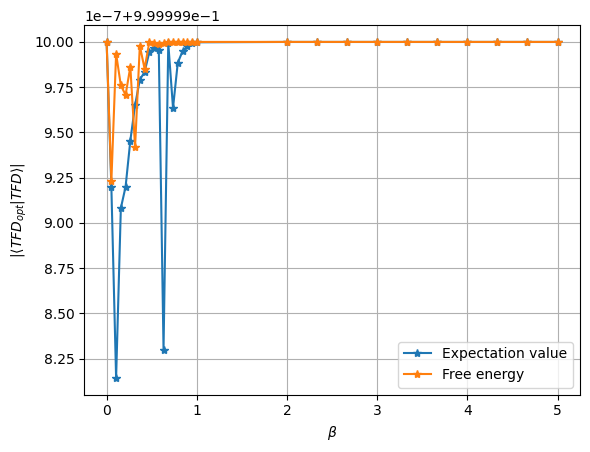

In [114]:
plt.plot(betas, results_expect, '*-', label='Expectation value')
plt.plot(betas, results_free_energy, '*-', label='Free energy')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$|\langle TFD_{opt} | TFD \rangle|$')
plt.legend()
plt.grid()
plt.show()

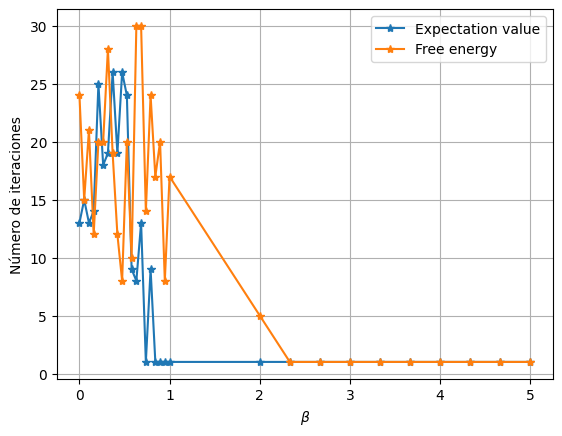

In [115]:
plt.plot(betas, niterExpect, '*-', label='Expectation value')
plt.plot(betas, niterFE, '*-', label='Free energy')
plt.xlabel(r'$\beta$')
plt.ylabel(r'Número de iteraciones')
plt.legend()
plt.grid()
plt.show()

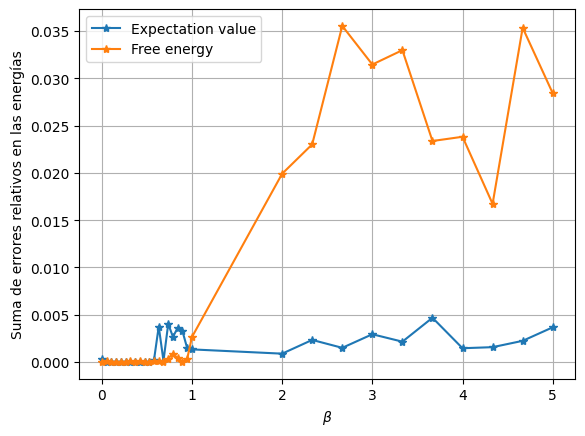

In [116]:
Eteo=np.sort(np.linalg.eig(matrizABX.to_matrix())[0])
Eexpect=[np.sort(energies_expect[i])*factor for i in range(len(betas))] 
Efreeenerg=[np.sort(energies_free_energy[i])*factor for i in range(len(betas))]
relerrorExpect=[1/(len(Eteo))*1/(len(Eteo))*sum([abs((Eexpect[i][j]-Eteo[j])/Eteo[j]) for j in range(len(Eteo))]) for i in range(len(betas))]
relerrorFE=[1/(len(Eteo))*sum([abs((Efreeenerg[i][j]-Eteo[j])/Eteo[j]) for j in range(len(Eteo))]) for i in range(len(betas))]
plt.plot(betas, relerrorExpect, '*-', label='Expectation value')
plt.plot(betas, relerrorFE, '*-', label='Free energy')
plt.xlabel(r'$\beta$')
plt.ylabel(r'Suma de errores relativos en las energías')
plt.legend()
plt.grid()
plt.show()

In [117]:
index=np.argmin(relerrorFE)

In [118]:
relerrorFE[index]

np.float64(6.700478286608819e-06)

In [119]:
results_expect

array([1.        , 0.99999992, 0.99999981, 0.99999991, 0.99999992,
       0.99999995, 0.99999997, 0.99999998, 0.99999998, 0.99999999,
       1.        , 1.        , 0.99999983, 1.        , 0.99999996,
       0.99999999, 0.99999999, 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])

In [120]:
results_free_energy

array([1.        , 0.99999992, 0.99999999, 0.99999998, 0.99999997,
       0.99999999, 0.99999994, 1.        , 0.99999999, 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])

In [121]:
# Energías obtenidas minimizando el valor esperado de la energía en el hamiltoniano total.
np.sort(energies_expect[index])*factor

array([-14388.49435344,  -5623.86154703,  -4456.19110702,  -4371.27355247,
         4336.35802548,   4428.7584984 ,   5623.37782957,  14451.32620651])

In [122]:
# Energías obtenidas minimizando el valor esperado de la energía libre.
np.sort(energies_free_energy[index])*factor

array([-14388.49435344,  -5623.86154703,  -4456.19110702,  -4371.27355247,
         4335.76862051,   4428.98744052,   5623.73829241,  14451.32620651])

In [123]:
# Valores teóricos para las energías.
np.sort(np.linalg.eig(matrizABX.to_matrix())[0])

array([-14388.49435344+0.j,  -5623.86154703+0.j,  -4456.19110702+0.j,
        -4371.27355247+0.j,   4335.68599523+0.j,   4428.93824614+0.j,
         5623.87011207+0.j,  14451.32620651+0.j])

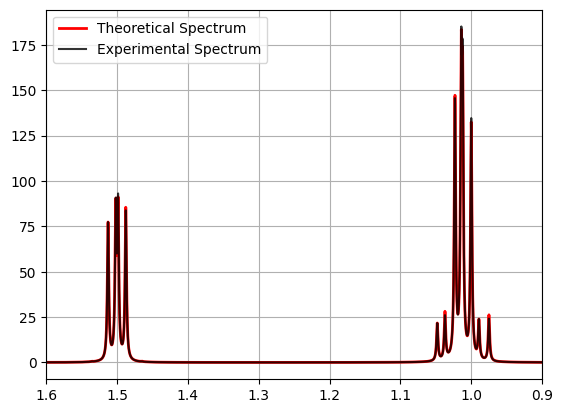

In [124]:
d=10**5
SW=10
reprSpectrum(shifts,J,d,SW,B,offset,energies_free_energy[index]*factor,UFE[index],TFE,xlim=[1.6,0.9])

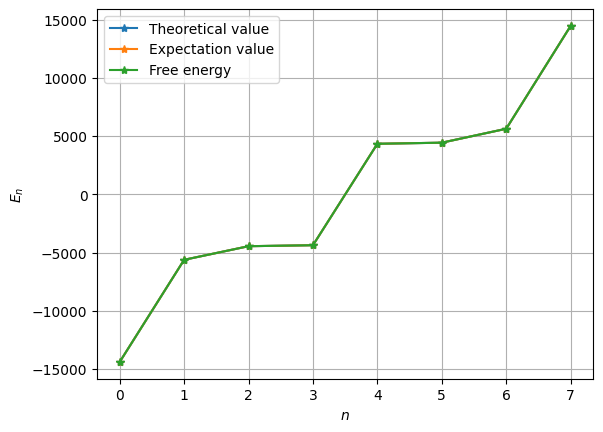

In [125]:
n=len(Eteo)
plt.plot(range(n), np.real(Eteo), '*-', label='Theoretical value')
plt.plot(range(n), Eexpect[index], '*-', label='Expectation value')
plt.plot(range(n), Efreeenerg[index], '*-', label='Free energy')
plt.xlabel(r'$n$')
plt.ylabel(r'$E_n$')
plt.legend()
plt.grid()
plt.show()

### ABC system

In [126]:
betas = list(np.linspace(0.001,1,20))+list(np.linspace(2,5,10))

In [127]:
# Construimos H para el sistema ABC.
offset=5
B=400
shifts=[1,1.025,1.05]
J=[8,10,8]
matrizABC=Hspin(shifts,J,offset,B)

In [128]:
results_expect, energies_expect, UExpect, niterExpect, tExpect, TExp=minimize_function(matrizABC,expectation_classic,betas)
results_free_energy, energies_free_energy, UFE, niterFE, tFE, TFE=minimize_function(matrizABC,free_energy,betas)

In [129]:
print('El tiempo que ha tardado la optimización minimizando el valor esperado de la energía en el hamiltoniano total es '+str(tExpect)+' s.')
print('El tiempo que ha tardado la optimización minimizando la energía libre es '+str(tFE)+' s.')

El tiempo que ha tardado la optimización minimizando el valor esperado de la energía en el hamiltoniano total es 7.859129428863525 s.
El tiempo que ha tardado la optimización minimizando la energía libre es 12.585304021835327 s.


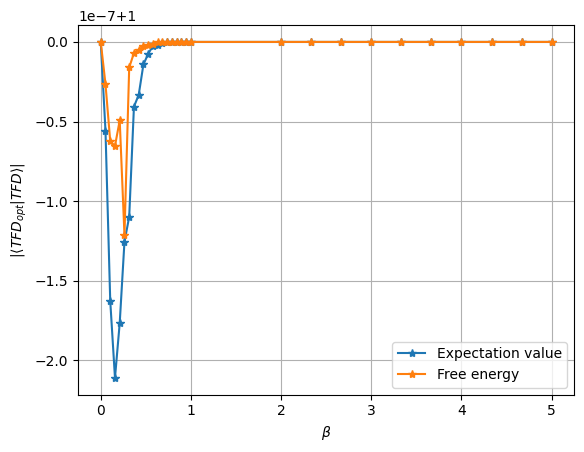

In [130]:
plt.plot(betas, results_expect, '*-', label='Expectation value')
plt.plot(betas, results_free_energy, '*-', label='Free energy')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$|\langle TFD_{opt} | TFD \rangle|$')
plt.legend()
plt.grid()
plt.show()

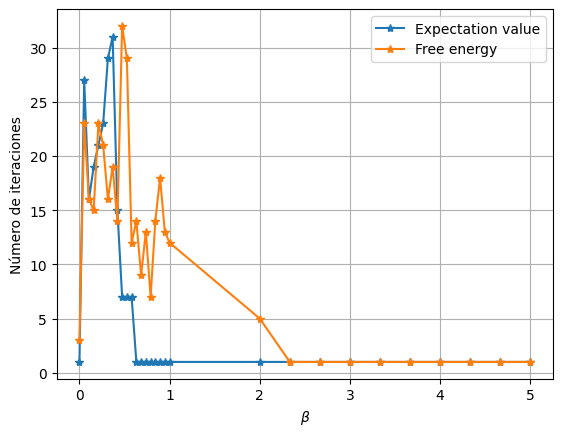

In [131]:
plt.plot(betas, niterExpect, '*-', label='Expectation value')
plt.plot(betas, niterFE, '*-', label='Free energy')
plt.xlabel(r'$\beta$')
plt.ylabel(r'Número de iteraciones')
plt.legend()
plt.grid()
plt.show()

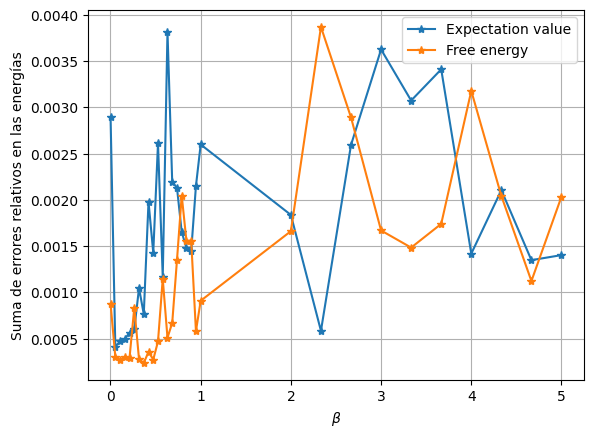

In [132]:
Eteo=np.sort(np.linalg.eig(matrizABC.to_matrix())[0])
Eexpect=[np.sort(energies_expect[i])*factor for i in range(len(betas))] 
Efreeenerg=[np.sort(energies_free_energy[i])*factor for i in range(len(betas))]
relerrorExpect=[1/(len(Eteo))*sum([abs((Eexpect[i][j]-Eteo[j])/Eteo[j]) for j in range(len(Eteo))]) for i in range(len(betas))]
relerrorFE=[1/(len(Eteo))*sum([abs((Efreeenerg[i][j]-Eteo[j])/Eteo[j]) for j in range(len(Eteo))]) for i in range(len(betas))]
plt.plot(betas, relerrorExpect, '*-', label='Expectation value')
plt.plot(betas, relerrorFE, '*-', label='Free energy')
plt.xlabel(r'$\beta$')
plt.ylabel(r'Suma de errores relativos en las energías')
plt.legend()
plt.grid()
plt.show()

In [133]:
index=np.argmin(relerrorFE)

In [134]:
relerrorFE[index]

np.float64(0.0002375152717908051)

In [135]:
results_expect

array([1.        , 0.99999994, 0.99999984, 0.99999979, 0.99999982,
       0.99999987, 0.99999989, 0.99999996, 0.99999997, 0.99999999,
       0.99999999, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])

In [136]:
results_free_energy

array([1.        , 0.99999997, 0.99999994, 0.99999993, 0.99999995,
       0.99999988, 0.99999998, 0.99999999, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])

In [137]:
# Energías obtenidas minimizando el valor esperado de la energía en el hamiltoniano total.
np.sort(energies_expect[index])*factor

array([-14944.55625313,  -5085.75050383,  -5012.24343415,  -4928.24372415,
         4917.18897956,   4980.59117373,   5046.77609984,  15026.23766212])

In [138]:
# Energías obtenidas minimizando el valor esperado de la energía libre.
np.sort(energies_free_energy[index])*factor

array([-14944.55625313,  -5085.75050383,  -5012.24343415,  -4928.24372415,
         4909.21003233,   4973.52582472,   5061.82039608,  15026.23766212])

In [139]:
# Valores teóricos para las energías.
np.sort(np.linalg.eig(matrizABC.to_matrix())[0])

array([-14944.55625313+0.j,  -5085.75050383+0.j,  -5012.24343415+0.j,
        -4928.24372415+0.j,   4904.51413459+0.j,   4978.02120427+0.j,
         5062.02091427+0.j,  15026.23766212+0.j])

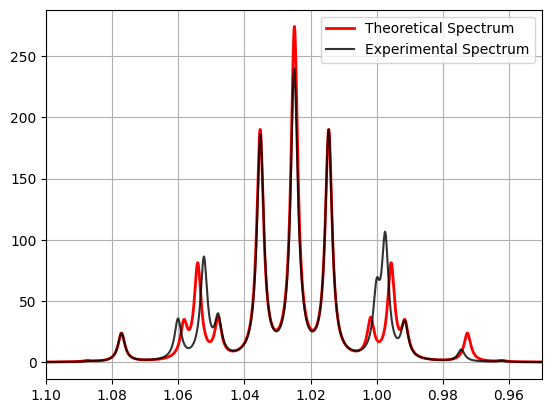

In [140]:
d=10**5
SW=10
reprSpectrum(shifts,J,d,SW,B,offset,energies_free_energy[index]*factor,UFE[index],TFE,xlim=[1.1,0.95])

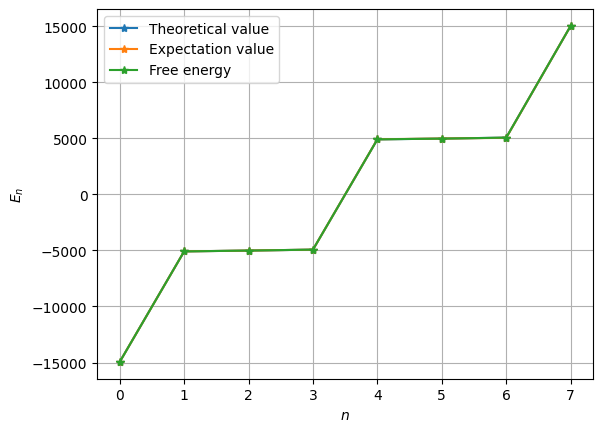

In [141]:
n=len(Eteo)
plt.plot(range(n), np.real(Eteo), '*-', label='Theoretical value')
plt.plot(range(n), Eexpect[index], '*-', label='Expectation value')
plt.plot(range(n), Efreeenerg[index], '*-', label='Free energy')
plt.xlabel(r'$n$')
plt.ylabel(r'$E_n$')
plt.legend()
plt.grid()
plt.show()

### AMPX system

In [202]:
#betas = list(np.linspace(0.001,1,100))+list(np.linspace(1,10,100))
betas=[0.2]

In [203]:
# Construimos H para el sistema AMPX.
offset=0
B=400
shifts=[1,1.3,2,2.5]
J=[10,7,2,15,9,20]
matrizAMPX=Hspin(shifts,J,offset,B)

In [204]:
results_expect, energies_expect, UExpect, niterExpect, tExpect, TExp=minimize_function(matrizAMPX,expectation_classic,betas)
results_free_energy, energies_free_energy, UFE, niterFE, tFE, TFE=minimize_function(matrizAMPX,free_energy,betas)

In [205]:
print('El tiempo que ha tardado la optimización minimizando el valor esperado de la energía en el hamiltoniano total es '+str(tExpect)+' s.')
print('El tiempo que ha tardado la optimización minimizando la energía libre es '+str(tFE)+' s.')

El tiempo que ha tardado la optimización minimizando el valor esperado de la energía en el hamiltoniano total es 6.00885534286499 s.
El tiempo que ha tardado la optimización minimizando la energía libre es 6.8237059116363525 s.


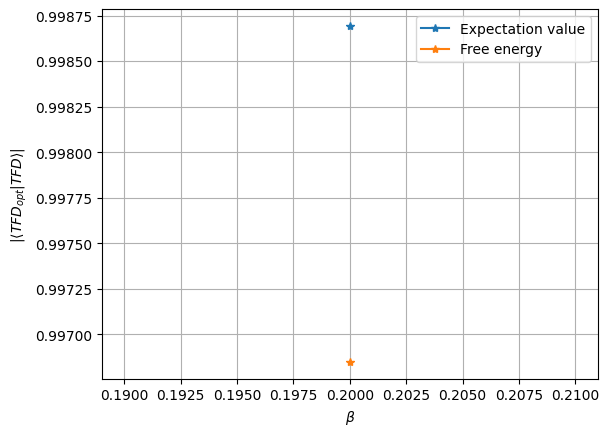

In [206]:
plt.plot(betas, results_expect, '*-', label='Expectation value')
plt.plot(betas, results_free_energy, '*-', label='Free energy')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$|\langle TFD_{opt} | TFD \rangle|$')
plt.legend()
plt.grid()
plt.show()

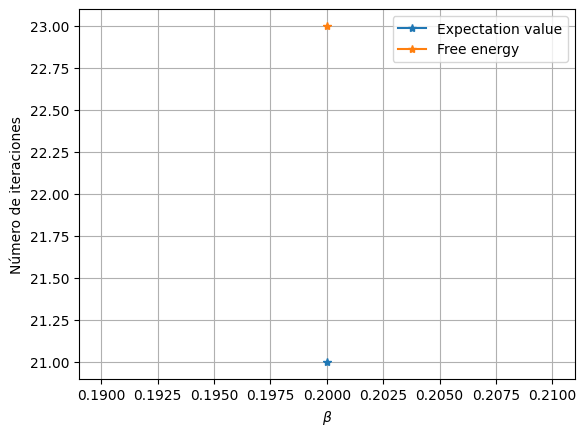

In [207]:
plt.plot(betas, niterExpect, '*-', label='Expectation value')
plt.plot(betas, niterFE, '*-', label='Free energy')
plt.xlabel(r'$\beta$')
plt.ylabel(r'Número de iteraciones')
plt.legend()
plt.grid()
plt.show()

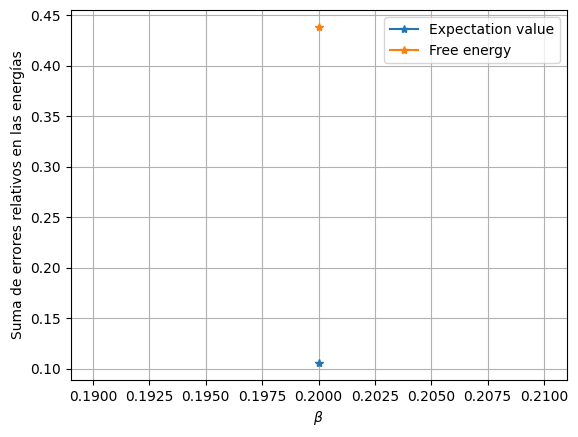

In [208]:
Eteo=np.sort(np.linalg.eig(matrizAMPX.to_matrix())[0])
Eexpect=[np.sort(energies_expect[i])*factor for i in range(len(betas))] 
Efreeenerg=[np.sort(energies_free_energy[i])*factor for i in range(len(betas))]
relerrorExpect=[1/(len(Eteo))*sum([abs((Eexpect[i][j]-Eteo[j])/Eteo[j]) for j in range(len(Eteo))]) for i in range(len(betas))]
relerrorFE=[1/(len(Eteo))*sum([abs((Efreeenerg[i][j]-Eteo[j])/Eteo[j]) for j in range(len(Eteo))]) for i in range(len(betas))]
plt.plot(betas, relerrorExpect, '*-', label='Expectation value')
plt.plot(betas, relerrorFE, '*-', label='Free energy')
plt.xlabel(r'$\beta$')
plt.ylabel(r'Suma de errores relativos en las energías')
plt.legend()
plt.grid()
plt.show()

In [209]:
index=np.argmin(relerrorFE)

In [210]:
relerrorFE[index]

np.float64(0.4384948447756873)

In [211]:
results_expect

array([0.99869311])

In [212]:
results_free_energy

array([0.99684852])

In [213]:
# Energías obtenidas minimizando el valor esperado de la energía en el hamiltoniano total.
np.sort(energies_expect[index])*factor

array([-8446.17637308, -5699.80129334, -5362.06006256, -3626.36683616,
       -2595.78678062, -2402.00952698,  -974.53979077,  -422.58296988,
         350.7935606 ,   861.97189797,  2319.85798961,  2582.22374534,
        3690.7578487 ,  5236.87066989,  5842.75121084,  8644.09671044])

In [214]:
# Energías obtenidas minimizando el valor esperado de la energía libre.
np.sort(energies_free_energy[index])*factor

array([-8445.52320947, -5271.30106419, -4998.80095567, -4546.38714799,
       -2273.74855119, -2139.03960949, -1056.59836031,  -874.26008214,
         958.20873655,  1015.67393247,  1898.09504557,  2367.34414666,
        4391.26276643,  5162.99849659,  5168.63230937,  8643.44354682])

In [215]:
# Valores teóricos para las energías.
np.sort(np.linalg.eig(matrizAMPX.to_matrix())[0])

array([-8446.17184918+0.j, -5994.14903683+0.j, -5285.90427429+0.j,
       -3553.20868453+0.j, -2771.03297639+0.j, -2257.00203988+0.j,
       -1057.26863451+0.j,  -298.71906901+0.j,   207.73507448+0.j,
         959.73571379+0.j,  2260.06760694+0.j,  2761.62955447+0.j,
        3487.32163529+0.j,  5270.28064407+0.j,  6072.59414922+0.j,
        8644.09218635+0.j])

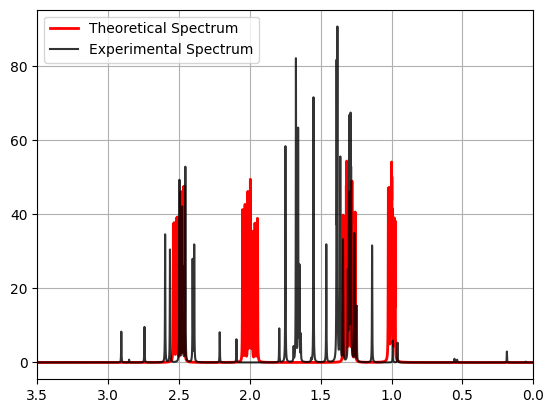

In [216]:
d=10**5
SW=10
reprSpectrum(shifts,J,d,SW,B,offset,energies_free_energy[index]*factor,UFE[index],TFE,xlim=[3.5,0])

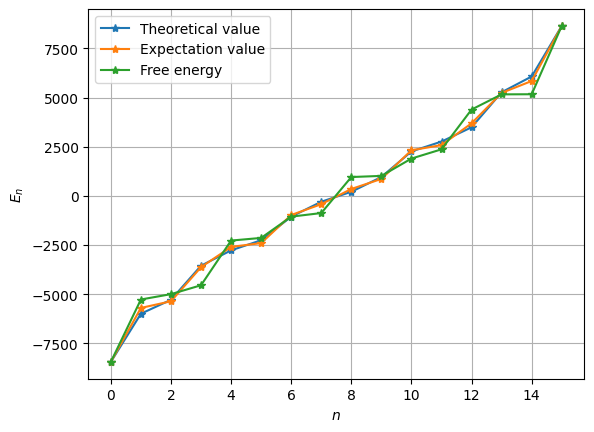

In [217]:
n=len(Eteo)
plt.plot(range(n), Eteo, '*-', label='Theoretical value')
plt.plot(range(n), Eexpect[index], '*-', label='Expectation value')
plt.plot(range(n), Efreeenerg[index], '*-', label='Free energy')
plt.xlabel(r'$n$')
plt.ylabel(r'$E_n$')
plt.legend()
plt.grid()
plt.show()

### AA'MM'X system

In [18]:
betas = [3]

In [19]:
# Construimos H para el sistema AA'MM'X.
offset=5
B=400
shifts=[5,5,5.4,5.4,6]
J=[100,20,25,5,35,30,9,200,40,45]
matrizAA2MM2X=Hspin(shifts,J,offset,B)

In [20]:
results_expect, energies_expect, UExpect, niterExpect, tExpect, TExp=minimize_function(matrizAA2MM2X,expectation_classic,betas)
results_free_energy, energies_free_energy, UFE, niterFE, tFE, TFE=minimize_function(matrizAA2MM2X,free_energy,betas)

0.0007948875427246094
0.0009188652038574219
0.0006608963012695312
0.0008363723754882812
0.0009021759033203125
0.0007588863372802734
0.0008523464202880859
0.0006530284881591797
0.0007121562957763672
0.0007712841033935547
0.0007748603820800781
0.0006287097930908203
0.0008318424224853516
0.0006778240203857422
0.0007016658782958984
0.0006716251373291016
0.0006999969482421875
0.0006384849548339844
0.0006692409515380859
0.0007712841033935547
0.0007691383361816406
0.0006301403045654297
0.0007331371307373047
0.0006375312805175781
0.0008196830749511719
0.0008392333984375
0.0007145404815673828
0.0007174015045166016
0.000705718994140625
0.0008716583251953125
0.0008006095886230469
0.0008757114410400391
0.0009226799011230469
0.0010600090026855469
0.0009524822235107422
0.000823974609375
0.0008244514465332031
0.0009024143218994141
0.0008258819580078125
0.000820159912109375
0.0009315013885498047
0.0008263587951660156
0.0008127689361572266
0.0008332729339599609
0.000728607177734375
0.000784635543823242

In [21]:
print('El tiempo que ha tardado la optimización minimizando el valor esperado de la energía en el hamiltoniano total es '+str(tExpect)+' s.')
print('El tiempo que ha tardado la optimización minimizando la energía libre es '+str(tFE)+' s.')

El tiempo que ha tardado la optimización minimizando el valor esperado de la energía en el hamiltoniano total es 0.0018048286437988281 s.
El tiempo que ha tardado la optimización minimizando la energía libre es 0.0018126964569091797 s.


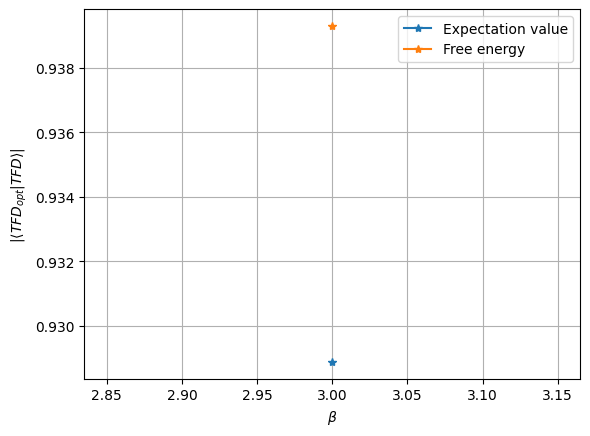

In [22]:
plt.plot(betas, results_expect, '*-', label='Expectation value')
plt.plot(betas, results_free_energy, '*-', label='Free energy')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$|\langle TFD_{opt} | TFD \rangle|$')
plt.legend()
plt.grid()
plt.show()

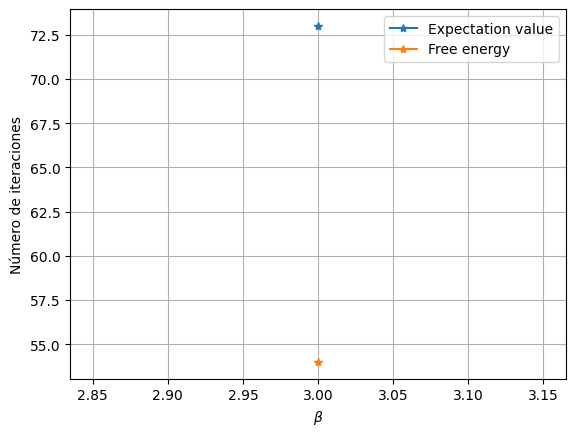

In [23]:
plt.plot(betas, niterExpect, '*-', label='Expectation value')
plt.plot(betas, niterFE, '*-', label='Free energy')
plt.xlabel(r'$\beta$')
plt.ylabel(r'Número de iteraciones')
plt.legend()
plt.grid()
plt.show()

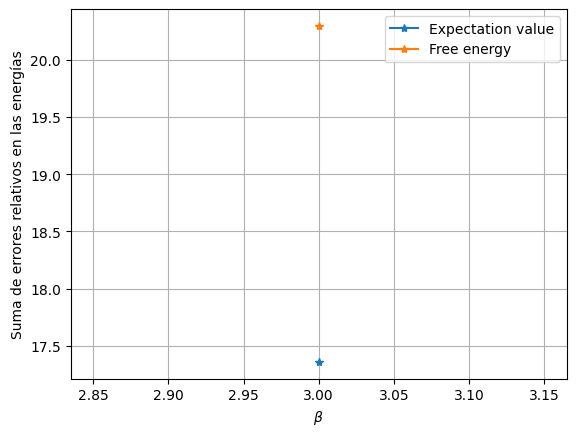

In [24]:
Eteo=np.sort(np.linalg.eig(matrizAA2MM2X.to_matrix())[0])
Eexpect=[np.sort(energies_expect[i])*factor for i in range(len(betas))] 
Efreeenerg=[np.sort(energies_free_energy[i])*factor for i in range(len(betas))]
relerrorExpect=[sum([abs((Eexpect[i][j]-Eteo[j])/Eteo[j]) for j in range(len(Eteo))]) for i in range(len(betas))]
relerrorFE=[sum([abs((Efreeenerg[i][j]-Eteo[j])/Eteo[j]) for j in range(len(Eteo))]) for i in range(len(betas))]
plt.plot(betas, relerrorExpect, '*-', label='Expectation value')
plt.plot(betas, relerrorFE, '*-', label='Free energy')
plt.xlabel(r'$\beta$')
plt.ylabel(r'Suma de errores relativos en las energías')
plt.legend()
plt.grid()
plt.show()

In [25]:
results_expect

array([0.92888561])

In [26]:
results_free_energy

array([0.93930308])

In [27]:
# Energías obtenidas minimizando el valor esperado de la energía en el hamiltoniano total.
np.sort(energies_expect[-1])*factor

array([-2636.94494986, -2255.78439411, -1901.68693907, -1642.68472045,
       -1569.02411073, -1496.36590584, -1420.71377138, -1296.26038951,
       -1226.77800012,  -939.01531343,  -494.47187172,  -261.81498594,
        -217.37797947,  -150.07736529,   -10.63857255,   146.633769  ,
         171.7465462 ,   232.31118997,   329.62852558,   375.60261154,
         383.05034429,   387.71377625,   568.74658189,   602.03815215,
         725.0492517 ,  1066.55451319,  1285.47597995,  1459.61238908,
        1917.16362856,  2246.67366509,  2606.04212461,  3015.59622039])

In [28]:
# Energías obtenidas minimizando el valor esperado de la energía libre.
np.sort(energies_free_energy[-1])*factor

array([-2643.61531292, -2257.78201839, -1990.89341947, -1887.77649297,
       -1596.8014307 , -1491.40946544, -1445.65912559, -1359.54685187,
       -1046.09369767,  -875.31324521,  -841.41330846,  -822.47469237,
        -495.00710681,    81.81534232,    82.30519488,   158.24710967,
         196.69190041,   207.60843738,   219.12086156,   275.34897593,
         289.72800343,   553.42559303,   615.82278974,   701.18468961,
         752.57405743,  1065.59575488,  1395.99949554,  1662.37567212,
        2438.51666441,  2444.49990571,  2569.84054428,  3043.08517554])

In [29]:
# Valores teóricos para las energías.
np.sort(np.linalg.eig(matrizAA2MM2X.to_matrix())[0])

array([-2671.16799623+0.j, -2289.83386065+0.j, -2064.73171903+0.j,
       -2042.86777602+0.j, -2019.28078708+0.j, -1881.15102868+0.j,
       -1686.36134564+0.j, -1462.41138025+0.j, -1437.97058809+0.j,
        -870.18099194+0.j,  -822.20712396+0.j,  -755.23959896+0.j,
        -560.26468625+0.j,  -157.508379  +0.j,   -45.73521399+0.j,
         -16.10845732+0.j,    95.77252786+0.j,   213.41043546+0.j,
         440.95985422+0.j,   450.43584448+0.j,   471.72258102+0.j,
         493.57600948+0.j,   589.75392364+0.j,   764.41079091+0.j,
        1122.32788973+0.j,  1741.40378296+0.j,  1742.8215996 +0.j,
        1754.05433433+0.j,  2239.83502476+0.j,  2705.32190092+0.j,
        2895.73239279+0.j,  3061.48204092+0.j])

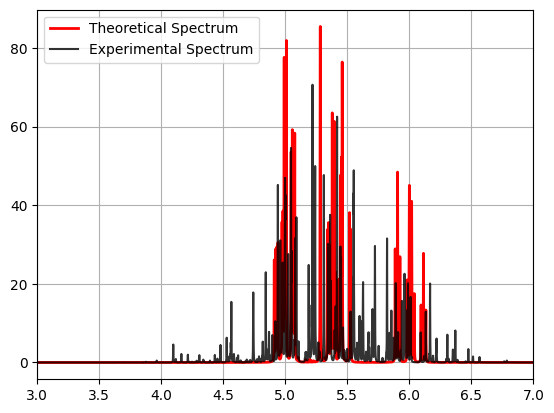

In [30]:
SW=10
d=10**5
reprSpectrum(shifts,J,d,SW,B,offset,energies_free_energy[-1]*factor,UFE[-1], TFE, xlim=[3,7])

/mnt/netapp2/Store_uni/home/usc/ie/cfl/conda/envs/Cesar/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/mnt/netapp2/Store_uni/home/usc/ie/cfl/conda/envs/Cesar/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


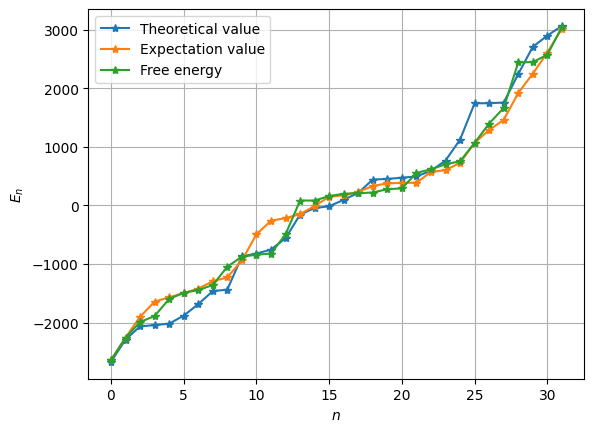

In [31]:
n=len(Eteo)
plt.plot(range(n), Eteo, '*-', label='Theoretical value')
plt.plot(range(n), Eexpect[-1], '*-', label='Expectation value')
plt.plot(range(n), Efreeenerg[-1], '*-', label='Free energy')
plt.xlabel(r'$n$')
plt.ylabel(r'$E_n$')
plt.legend()
plt.grid()
plt.show()

### 6Spins

In [33]:
betas = [0.2]

In [37]:
offset=4
B=400
shifts=[5,5,5.4,5.4,6,6.5]
J=[100,20,25,0,0,35,30,9,0,200,40,20,45,15,35]
H6Spins=Hspin(shifts,J,offset,B)

In [38]:
results_expect, energies_expect, UExpect, niterExpect, tExpect, TExp=minimize_function(H6Spins,expectation_classic,betas)
results_free_energy, energies_free_energy, UFE, niterFE, tFE, TFE=minimize_function(H6Spins,free_energy,betas)

Ansatz done
Empieza el bucle de betas
Empieza la minimizacion
Acaba la minimizacion
Ansatz done
Empieza el bucle de betas
Empieza la minimizacion
Acaba la minimizacion


In [39]:
print('El tiempo que ha tardado la optimización minimizando el valor esperado de la energía en el hamiltoniano total es '+str(tExpect)+' s.')
print('El tiempo que ha tardado la optimización minimizando la energía libre es '+str(tFE)+' s.')

El tiempo que ha tardado la optimización minimizando el valor esperado de la energía en el hamiltoniano total es 1083.1042516231537 s.
El tiempo que ha tardado la optimización minimizando la energía libre es 1418.8804233074188 s.


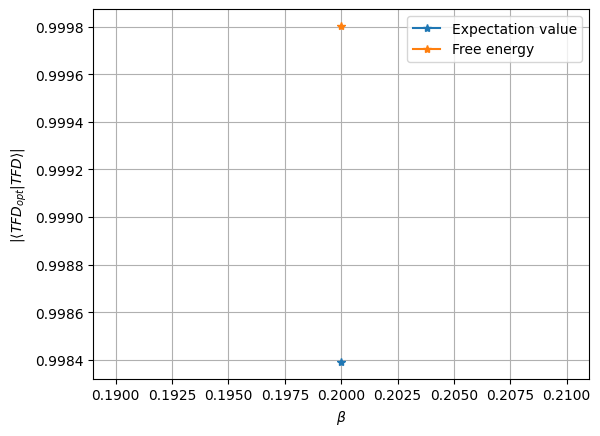

In [40]:
plt.plot(betas, results_expect, '*-', label='Expectation value')
plt.plot(betas, results_free_energy, '*-', label='Free energy')
plt.xlabel(r'$\beta$')
plt.ylabel(r'$|\langle TFD_{opt} | TFD \rangle|$')
plt.legend()
plt.grid()
plt.show()